<a href="https://colab.research.google.com/github/semla/notebooks/blob/master/An_attempt_to_classify_sign_language_using_pose_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction & background

*Pose detection to classify sign language. An attempt to classify the digits 0-9 in the swedish sign language using [Openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose).*

Link to **[video](https://drive.google.com/open?id=1N4lJXzOp_Jvp3Y0BrXYCPtdbB5Vn5Cen)** with a short description of this notebook.




## Openpose
Openpose is a library for real-time multi-person keypoint detection. Instead of Tensorflow it uses [caffe](https://caffe.berkeleyvision.org/). In this lab I run openpose on videos containing signlanguage and openpose generates data in different formats that is then used for training.

## Lack of data

  There is no way I could gather sufficient data to train a model from scratch. So I have been focusing on ways around this problem. I thought it would be interesting to see if I could represent a video clip in one image, thereby being able to make use of pretrained model and image augmentation. That should be a big help regarding the lack of data. I have also explored ways of cleaning the data by removing noise.
  
 ## Results
The results are an utter failure. While the data coming from openpose can be considered as feature extaction with low ratio of noise, there is still not enough samples for the models I have tried to learn. I have explored different ways of preprocessing the data, including ways of turning video into representative single images and thereby being able to use a pretrained model,  and image augmentation. While I thought I was on the right track with [expressive images](#scrollTo=gwTHtAQn-bhF), the only model showing some ability to learn is the one with [GRU](#scrollTo=-xBPwn-mGgE0) which uses data of positions as time-series.

Alot of time was spent on getting and cleaning data, which I suspect is common for "real" projects. In hindsight it may have been better to choose a problem with easier access to data.

##Notes


*   This is a work in progress
*   *Parts of this notebook are heavily inspired from https://colab.research.google.com/github/tugstugi/dl-colab-notebooks/blob/master/notebooks/OpenPose.ipynb*

*   You may have to connect your google drive or change base_dir to be able to run this notebook
*   Building openpose takes a while
*   Training was first attempted on the raw data from openpose on different models,  [Link](#scrollTo=YMjoBY92cuDu).
*   Second attempt seems more promising, where training is done on one image generated from a movie. [Link](#scrollTo=TmhGtv1Z7cvg).

# Installation

## Install libraries
### and set some constants

In [0]:
use_tf2 = True # Use Tensorflow 2

if use_tf2:
  !pip install -q tf-nightly-2.0-preview
  #!pip install tensorflow==2.0.0-alpha0
  # Load the TensorBoard notebook extension
  # %load_ext tensorboard.notebook
  from tensorflow.keras.callbacks import TensorBoard

import os, glob, subprocess, time, imageio
from os.path import exists, join, basename, splitext, dirname
from os import listdir

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

if not use_tf2:
  tf.enable_eager_execution() # eager enabled by default in tf 2

from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot

from tensorflow.keras import models, layers # need to be explicitly imported when adding conv_base for some reason.
from tensorflow.keras.applications import VGG16 # importing from tf.keras bc of some alpha problem with tf2.0: https://github.com/keras-team/keras/issues/12379

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint # does not work if imported from keras..?

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import json
#import datetime, time, os

from skimage.transform import resize
import imageio
from IPython.display import SVG

print('TF-version: ' +tf.__version__)

# the movies & generated pose data \
# are saved to relative paths from base_dir.
base_dir = "/content/gdrive/My Drive/stud/dl-umu/lab2/"

#train_dir = f"{base_dir}data/train/" # can be overridden
#train_dir = f"{base_dir}data/train-plot-imgs/" # can be overridden
train_dir = f"{base_dir}20-5-train-img/"
test_dir = f"{base_dir}data/test/"

img_size = 300 # square, size of the images used for classification

     |████████████████████████████████| 88.0MB 1.8MB/s 
     |████████████████████████████████| 3.1MB 24.2MB/s 
     |████████████████████████████████| 430kB 46.4MB/s 
     |████████████████████████████████| 61kB 20.8MB/s 
ERROR: thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.


Using TensorFlow backend.


TF-version: 2.0.0-dev20190527


## Install OpenPose
#### & imagemagick

Installing openpose takes time. I gather openpose can not run on tpu.

In [0]:
def install_openpose_imagemagick():
  %cd /content
  !pwd
  !ls -l
  !apt-get install -y imagemagick # relatively quick

  git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
  project_name = splitext(basename(git_repo_url))[0]
  print(exists(project_name))

  if not exists(project_name):
    # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
    # install new CMake becaue of CUDA10
    !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
    !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
    # clone openpose
    !git clone -q --depth 1 $git_repo_url
    !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
    # install system dependencies
    !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
    # install python dependencies
    # !pip install -q youtube-dl
    # build openpose
    !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
    
install_openpose_imagemagick()

## Mount Google drive

In [0]:
# if base_dir is set to google drive - it has to be mounted.
# it should also be possible to use /home etc for non persistence.
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

## Data

* JSON
  
 https://drive.google.com/open?id=1S03Ta9JjDPvG-KqIVw_qcOZ-0T_iiqKI


* Images, generated from video sequences in 2 different ways.

  https://drive.google.com/open?id=1tpcEofEhwN-0d2cBw-D-ycCjk7xw4K07

  https://drive.google.com/open?id=11lLtBgNwM9hZsKGeT1UowAIsSwRVT8hn



## Functions
Functions used later in the notebook

**pose_detection**, function for running openpose on movies. Generates json-data, overlay on original or only overlay. Called to generate training or testing data.

**predict image**, function for predicting the class (number) of an image.

**gen_comp_img**, function for generating an image from a sequence using ffmpeg and imagemagick to process the frames from openpose into a single representative image.

**plot_activation**, function for plotting the activations of an image run through the model.

In [0]:
def pose_detection( video, path, gen_overlay=None, gen_stickfig=None, label='no', i = 0 ):
  print ( ' video to run op on: ', video)
  print(subprocess.run(["mkdir", "-p", path]))
  %cd /content/openpose
  print(label)
  # todo: for now json is always & only generated when gen_stickfig
  file = basename(video).replace('orig_',"") # todo - only named orig in training?
  if gen_overlay:
    vidname = f"{path}{label}_label_overlay_{splitext(file)[0]}.avi"
    res = subprocess.check_output(["./build/examples/openpose/openpose.bin", "--face", "--hand", "--video", video, "keypoint_scale", "3", "--display", "0", "--write_video", vidname])#f"{base_dir}vid/processed/{i+1}.avi"])
    print(res.decode("utf-8"))
    gen_ovlerlay = vidname
  if gen_stickfig:
    vidname_stickfig = f"{path}{label}_label_only_overlay_{splitext(file)[0]}.avi"
    print('vidname_stickfig ', vidname_stickfig)
    res = subprocess.check_output(["./build/examples/openpose/openpose.bin", "--face", "--hand", "--video", video, "--write_json", f"{path}json{i+1}", "--disable-blending", "--display", "0", "--write_video", vidname_stickfig])
    print( res.decode("utf-8") )
    gen_stickfig = vidname_stickfig 
  return { "overlay": gen_overlay, "only_overlay":gen_stickfig }


def predict_image(img, model, correct_class=None):
  image = imageio.imread(img)
  print(image.shape)
  image = resize(image, (img_size, img_size), anti_aliasing=True)
  #image = image.reshape(img_size,img_size,3)
 
  # plot the image
  plt.imshow( image, cmap='gray', vmin=0, vmax=1)
  image = image.reshape(1,img_size,img_size,3)
  prediction = model.predict(image)
  print("image dims: " + str(image.shape))
  plt.show()
  print('Predicted class: ' + str(np.argmax (prediction)))
  if (correct_class):
    print('Correct class: ' + str( correct_class ))

# Generate composite image from movie
def gen_comp_img( video, path ):
  path = f"{path}frames/"
  print(f"path: {path}")
  print( subprocess.run(["mkdir", "-p", path]))
  print ( subprocess.check_output(["ffmpeg", "-i", video, path + "frame%03d.jpg"]))
  print('frames generated ')
    # got errors I think due to out of gpu mem, no idea if this can help?
  !sleep 1
  print ( subprocess.check_output(["convert", path + "frame*.jpg", "-evaluate-sequence", "mean", path + "average.jpg"]))
  print ( subprocess.check_output(["convert", path + "frame*.jpg", "-evaluate-sequence", "median", path + "median.jpg"]))
  print ( subprocess.run (["compare", "-fuzz", "2%", path + "median.jpg", path + "average.jpg", path + "comp-diff.jpg"]))
  return path + "comp-diff.jpg"


def plot_activation(model,image,name='', layer_nums=(1,2)):
  for i, layer in enumerate(model.layers):
    print(i)
    print(layer.name)
  
  plt.imshow(img[0])
  plt.show()
  # Extracts the outputs of the top 3 layers.
  print(len(model.layers))
  print( model.layers)
  print(layer_nums)
  layer_outputs = [layer.output for layer in model.layers[layer_nums[0] : layer_nums[1] ]]
  print( len(layer_outputs))
  # Creates a model that will return these outputs, given the model input
  activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
  activations = activation_model.predict(image)
  
  print(activation_model.summary())
  print(activations.shape)
  #print(activations)
  
  print("Length of the activations: " + str(len(activations))) # 3, the 3 layers
  # ValueError: could not broadcast input array from shape (28,28,64) into shape (1)
  #print("Shape of the first activation layer: " + str(activations[0].shape))
  #print("Shape of the second activation layer: " + str(activations[1].shape))
  #print("Shape of the third activation layer: " + str(activations[2].shape))
  #print('Descriptive name of the model: ' + name)
  
  # The 64:th is the last filter which seems to be the most interesting.
  # Probably because the highest level features are detected there.
  #plt.matshow( activations[0][0, :, :, 63], cmap='magma')
  for i in range(63):
    plt.matshow( activations[0, :, :, i], cmap='gray')
    plt.show()
  #plt.matshow( activations[1][0, :, :, 63], cmap='magma')
  #plt.show()

  
#x = 0 # the first image
#image = validation_images[x].reshape(1,28,28,1)
# the validation images are supposed to be the last

# predict_image(image, validation_labels[x], model) 
#img = imageio.imread('/content/gdrive/My Drive/stud/dl-umu/lab2/data/train/7/155794869141474_comp-diff.jpg')
#img = resize(img, (img_size, img_size), anti_aliasing=True)
#img = img.reshape(1,img_size,img_size,3)
#print(img.shape)

#plot_activation( pretrained_model.layers[0], img, '', (15,16))

##Demonstration of openpose

###Download videos
Download videos from sign-language dictionaries

In [0]:
# Download videos

download_dir = f"{base_dir}vid/"

def download_videos():
  videos_to_download = [
                        {"file": "https://teckensprakslexikon.su.se/movies/01/noll-01789-tecken.mp4", "label": 0},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/388974.mp4", "label": 0},\
                        {"file": "https://teckensprakslexikon.su.se/movies/01/nummer-ett-01289-tecken.mp4", "label": 1},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422266.mp4", "label": 1},\
                        {"file": "https://teckensprakslexikon.su.se/movies/01/nummer-tva-01297-tecken.mp4", "label": 2},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422268.mp4", "label": 2},\
                        {"file": "https://teckensprakslexikon.su.se/movies/01/nummer-tre-01305-tecken.mp4", "label": 3},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422270.mp4", "label": 3},\
                        {"file": "https://teckensprakslexikon.su.se/movies/01/nummer-fyra-01312-tecken.mp4","label":4},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422272.mp4", "label": 4},\
                        {"file": "https://teckensprakslexikon.su.se/movies/01/nummer-fem-01323-tecken.mp4", "label": 5},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422274.mp4", "label": 5},\
                        {"file": "https://teckensprakslexikon.su.se/movies/01/nummer-sex-01324-tecken.mp4", "label": 6},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422276.mp4", "label": 6},\
                        {"file": "https://teckensprakslexikon.su.se/movies/01/nummer-sju-01328-tecken.mp4", "label": 7},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422278.mp4", "label": 7},\
                        {"file": "https://teckensprakslexikon.su.se/movies/01/nummer-atta-01330-tecken.mp4", "label": 8},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422280.mp4", "label": 8},\
                        {"file": "https://teckensprakslexikon.su.se/movies/11/nio-11886-tecken.mp4", "label": 9},\
                        {"file": "https://media.spreadthesign.com/video/mp4/2/422282.mp4", "label": 9}\
                       ]

  #traning_labels = [1,1,2,2]

  #for i, video in enumerate(videos_to_download):
  for video in videos_to_download:
    #vidname="video" + str(video['label']) + ".mp4"
    vidname= f"orig_{basename(video['file'])}"
    res_dl=subprocess.check_output(["curl", video['file'], "--create-dirs", "--output",  f"{download_dir}{str(video['label'])}/{vidname}"])
    print( res_dl.decode("utf-8") )

# download_videos()

###Run openpose on downloaded videos.

In [0]:
def downloaded_vids_to_pose_detection( videos_to_process ): 
  # sort videos so the labeling is correct
  # print(videos_to_process)
  for i, video in enumerate(videos_to_process):
    # create videos, one with overlay on original and one with only overlay
    # output with one json folder per original movie.
    # label from directory name
    path = f"{dirname(video)}/" # todo, check so ends with /
    #print(path)
    label = basename(os.path.normpath(path))
    print(label)
    # file = basename(video).replace('orig_',"")
    #gen_stickfig==
    #gen_overlay=
    pose_detection( video, path, None, True, label, i )
    
videos_to_process = glob.glob(f"{download_dir}**/orig*.mp4") # downloaded videos are called orig
downloaded_vids_to_pose_detection(videos_to_process) 



0
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid2/0/orig_388974.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/0/'], returncode=0)
/content/openpose
0
vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/vid2/0/0_label_only_overlay_388974.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 16.311714 seconds.

0
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid2/0/orig_noll-01789-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/0/'], returncode=0)
/content/openpose
0
vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/vid2/0/0_label_only_overlay_noll-01789-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 

### Show videos

####Convert videos to mp4 if you want to show them on a webpage.

In [0]:
# convert to mp4, for showing on webpage..
# only matching names containing label
def convert_avi_to_mp4( videos_to_process ):
  for video in videos_to_process:
    outfile = splitext(video)[0]+".mp4"
    print (outfile)
    res_mp4 = subprocess.check_output(["ffmpeg", "-y", "-loglevel", "info", "-i", video, outfile])
    print (res_mp4.decode("utf-8"))

videos_to_process = glob.glob(f"{download_dir}**/*.avi", recursive=True)
#print(videos_to_process)
convert_avi_to_mp4( videos_to_process )

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/0/0_label_only_overlay_388974.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/0/0_label_only_overlay_noll-01789-tecken.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/1/1_label_only_overlay_nummer-ett-01289-tecken.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/1/1_label_only_overlay_422266.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/2/2_label_only_overlay_nummer-tva-01297-tecken.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/2/2_label_only_overlay_422268.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/3/3_label_only_overlay_nummer-tre-01305-tecken.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/3/3_label_only_overlay_422270.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/4/4_label_only_overlay_nummer-fyra-01312-tecken.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/4/4_label_only_overlay_422272.mp4

/content/gdrive/My Drive/stud/dl-umu/lab2/vid2/5/5_label_only_overlay_nummer-fem-01323-tecken.mp4

/

####Visualize the results.

In [0]:
def show_html_videos():
  #todo: dir as param
  from IPython.display import HTML
  html_videos =''
  def show_local_mp4_video(file_name, width=320, height=240):
    import io
    import base64
    video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
    return '''<video width="{0}" height="{1}" alt="test" controls>
                          <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                        </video>'''.format(width, height, video_encoded.decode('ascii'))

  videos_to_process = glob.glob(f"{download_dir}**/*label*.mp4")
  for i,video in enumerate(videos_to_process):
    html_video = show_local_mp4_video(video, width=320, height=240)
    html_videos += f"<td>{html_video}<br>{basename(video)}</td>"
    if (i+1) % 2 == 0:
      html_videos = f"<tr>{html_videos}</tr>"
    print(basename(video))

  html = f"<table><thead><tr><th colspan='2'>only openpose and overlayed on original</th>\
  </tr></thead><tbody>{html_videos}</tbody></table>"

  display(HTML(data=html))

  
show_html_videos()

0_label_only_overlay_388974.mp4
0_label_only_overlay_noll-01789-tecken.mp4
1_label_only_overlay_nummer-ett-01289-tecken.mp4
1_label_only_overlay_422266.mp4
2_label_only_overlay_nummer-tva-01297-tecken.mp4
2_label_only_overlay_422268.mp4
3_label_only_overlay_nummer-tre-01305-tecken.mp4
3_label_only_overlay_422270.mp4
4_label_only_overlay_nummer-fyra-01312-tecken.mp4
4_label_only_overlay_422272.mp4
5_label_only_overlay_nummer-fem-01323-tecken.mp4
5_label_only_overlay_422274.mp4
6_label_only_overlay_nummer-sex-01324-tecken.mp4
6_label_only_overlay_422276.mp4
7_label_only_overlay_nummer-sju-01328-tecken.mp4
7_label_only_overlay_422278.mp4
8_label_only_overlay_nummer-atta-01330-tecken.mp4
8_label_only_overlay_422280.mp4
9_label_only_overlay_nio-11886-tecken.mp4
9_label_only_overlay_422282.mp4


## Exploring ways to use the data from openpose

1. Openpose writes the x,y values (and confidence score) for the detected bodyparts to **json-files**, one file per frame. *Option one* is to use this data directly.
I gather this approach to the problem belongs into the timeseries category and I have explored using 1D convolutional layers and GRU. 
One drawback with this approach is that data-augmentation is not possible. But the data should be concecentrated, containing only relevant features.

2. *Option two* is to use images / movies with the data. I have explored different ways to preprocess the data into one image. Thereby it is very easy to benefit from a pretrained model.



# 1. Use the data from openpose directly (no movies or images)

The output from openpose is one json-file / frame. Each file contains four vectors:
*   pose_keypoints_2d: 75 values
*   face_keypoints_2d: 210 values
*   hand_left_keypoints_2d: 63 values
*   hand_right_keypoints_2d: 63 values

Each vector contains values `x1,y1,c1,x2,y2,c2..` where c is the confidence score. I decided the confidence score should be removed as I reckon it would confuse the model. Perhaps with massive amounts of data there could be an advantage to keeping it.

To further reduce noise I decided to select only the important parameters, the hand doing the sign. The mouth should really be used too as it is an important part of the sign, but time constraints made me skip that for now.
Again, if the amount of data was huge it is probably better to let the machine decide what is important. I imagine new correlations could be found that are not immediatly obvious.

The data is read into a 3d numpy-array with the first dimension for movie, the second for frames and the third for x and y values of body-parts. This is the same dimensionality that is commonly used for timeseries. But the videos are of different length so I decided to make each movie contan 150 frames, padding the shorter movies with zeros in the end.

Not being able to use image augmentation or pretrained models made me try this approach a little less.

Link to openpose output format: https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/output.md#hand-output-format

## Load the data

####Initialize numpy arrays and functions for loading json data



In [0]:
# Read data from jsonfiles into a 3d-array

# json_folders = glob.glob(f"{base_dir}vid/**/json*/") # num movies 0 based?, each generates a json folder
path = '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training'
json_folders = glob.glob(f"{path}/**/json*/", recursive=True ) # num movies 0 based?, each generates a json folder
#print(json_folders)


# todo: not the same lengths for videos. scale?
#training_data = np.zeros([len(json_folders),150, 411]) # whole body. int(411 - 411/3)]) #remove confidence score
training_data = np.zeros([len(json_folders),150, 42]) #21,2]) # only hand. shape[0] = movies, shape[1]=frames, shape[2] = positions
training_labels = np.full( (len(json_folders)), 99 ) # to make it int, 99 is just a number..

print('Dims training: ', training_data.shape)
print('Dims labels: ', training_labels.shape)


def load_hand(path):
      with open(path) as f:
        data=json.load(f)['people'][0]['hand_right_keypoints_2d']# todo, could be left
      del data[2::3] # delete confidence score
      arr = np.zeros([len(data)])
      arr = np.asarray(data)      
      #arr = np.delete(arr, list(range(2, arr.shape[0], 3)))
      return arr
    
def load_whole_pose(path):
  with open(path) as f:
      #data = np.asarray(json.load(f))
      data=json.load(f)['people'][0]
      pose=data['pose_keypoints_2d'] # 75
      face=data['face_keypoints_2d'] # 210
      hand_left=data['hand_left_keypoints_2d'] # 63
      hand_right=data['hand_right_keypoints_2d'] # 63
      # return one np array with all data as one long row
      arr = np.zeros(411)
      arr = np.concatenate((data['pose_keypoints_2d'], data['face_keypoints_2d'], data['hand_left_keypoints_2d'], data['hand_right_keypoints_2d']) ,axis=None)
      #arr = np.delete(arr,list(range(2, arr.shape[0], 3))) #remove confidence score
      #arr = arr.reshape(16,16)
      #print(f"arr: {arr.shape}")
      return arr #411  
    
def label_from_dir(dir):
  label = dir.split('/')[-3]
  if "(" in label: # dir in google drive can have same names but really something in () is added.
    label = label[0:1]
  return int(label) # label from directory name

def subtract_first_frame_hand(arr): # should make translation invariant, subtracts the base of the hand. todo: not done
  arr.reshape(arr.shape[0],21,2)  
  if hand_origin == 0:
    hand_origin = arr[0]
  arr = arr - hand_origin #arr[0]
  
  
def find_frame_with_sign(frames):
  print(frames.shape)
  # find the frame with the highest value of the root of the sign,
  # which should be the best describing frame
  frames = frames.reshape(frames.shape[0], 21,2)
  hand_root_positions = frames[:][0:]
  #plt.plot(hand_root_positions)
  #plt.show
  
def drop_frames_containing_zeros(frames):
  print('not done')
  

Dims training:  (54, 150, 42)
Dims labels:  (54,)


####Load training data

In [0]:
for i,json_folder in enumerate(json_folders):
  #print(json_folder)
  training_labels[i] = label_from_dir(json_folder) 
  json_files = glob.glob(f"{json_folder}/*.json")
  for j,json_file in enumerate(json_files):
    #print(json_file) # appear to be in order
    #training_data[i] = load_whole_pose(json_file)
    #training_data[i,j] = load_whole_pose(json_file)
    arr = load_hand(json_file)
    training_data[i,j] = arr
    #np.append(training_data, load_whole_pose(json_file), axis=0)
  
print(training_data.shape)
print(training_data[0])
print(training_labels.shape)
print(training_labels[0])


####Sketches (not used)

In [0]:
print('Dims training: ', training_data.shape)

hand_root_positions = np.zeros((training_data.shape[0],150,2))
print(hand_root_positions.shape)
print(training_data[0][0][1])
for i,frames in enumerate(training_data):
  print(frames.shape)
  mask = frames[:][:][1]
  print('mask ', mask)
#  x = frames[mask]
  for j,frame in enumerate(x):
    pos = frame.reshape(21,2)
    #print(frame.shape)
    plt.plot(frame[0][1])
    print((frame[0][1]))
  plt.show()
  #print(hand_root_positions.shape)
  #find_frame_with_sign(frames)
  
print(hand_root_positions)

Dims training:  (34, 150, 42)
(34, 150, 2)
0.0
(150, 42)
mask  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


NameError: ignored

(34, 150, 1)
(150, 1)
(150, 1)
(34, 150, 1)
(1825,)


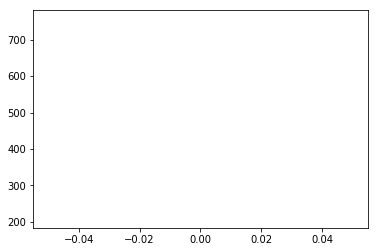

In [0]:
root_pos = training_data[:,:,1:2]
#print(root_pos)
print(root_pos.shape)
print(root_pos[0].shape)
mask = root_pos > 1
#print(type(mask[0,0]))
print(root_pos[0].shape)
print(mask.shape)
rp_cleaned = root_pos[np.array(mask)]

print(rp_cleaned.shape)
#plt.plot(training_data[0:,:,1])

for pos in rp_cleaned:
  plt.plot(pos)

In [0]:
mask[0,149,0]

IndexError: ignored

In [0]:
training_data[(::),1].shape

SyntaxError: ignored

## Explore the data
Plot the data to find useful stuff. 

#### Plot all values in a sample
Plot X and Y values for some samples. The plots show that there are 0 values in the data where openpose have failed to detect a feature.

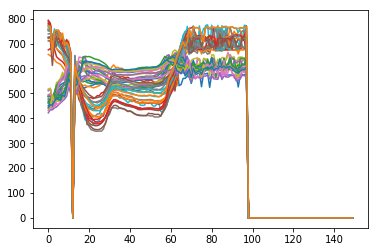

3


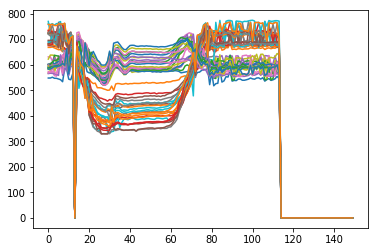

4


6


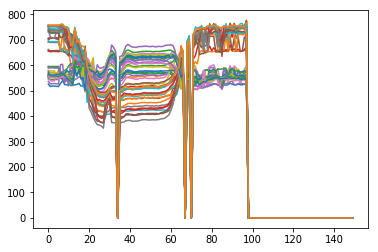

8


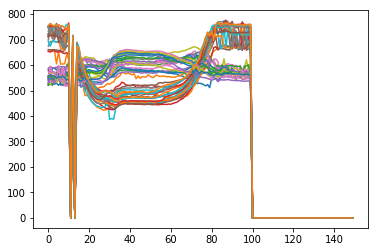

9


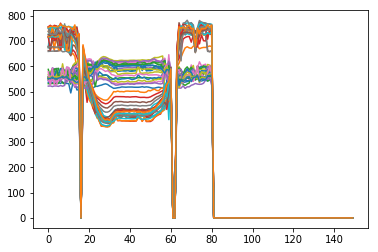

0


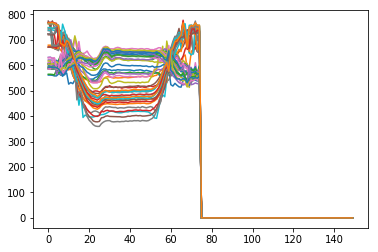

7


In [0]:
for i,sign in enumerate(training_data):
  plt.plot(sign)
  plt.show()
  print(training_labels[i])
  if i>5:
    break
#print(training_data[0].shape)

#### Not used

One image per video is generated containing the most relevant frames. This is another approach to solve the problem with  small amount of data, by having only very relevant data.

34
0
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3 (1)/json8/
98  frames
new best frame  0  data:  612.7356857142858
new best frame  2  data:  581.6565714285714
new best frame  13  data:  567.7763428571429
new best frame  14  data:  553.7500285714285
new best frame  15  data:  552.6614285714285
new best frame  16  data:  538.5434857142858
new best frame  17  data:  535.2546857142856
new best frame  18  data:  527.6958285714286
new best frame  19  data:  516.7544857142857
new best frame  20  data:  513.0722571428572
new best frame  21  data:  507.8524
new best frame  22  data:  503.77042857142857
new best frame  23  data:  502.2113142857143
new best frame  24  data:  501.94422857142854
new best frame  25  data:  501.9178285714286


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


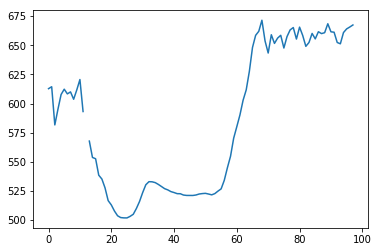

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3 (1)/json8/2019-05-08-134009_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3 (1)/json8/2019-05-08-134009_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3 (1)/json8/2019-05-08-134009_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3 (1)/json8/2019-05-08-134009_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3 (1)/json8/2019-05-08-134009_000000000024_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3 (1)/json8/2019-05-08-134009_000000000025_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3 (1)/json8/2019-05-08-134009_000000000026_keypoin

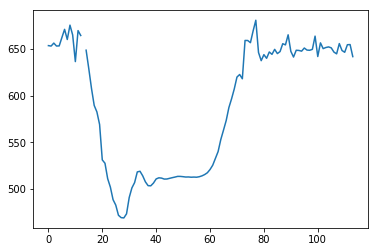

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4 (1)/json6/2019-05-08-134018_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4 (1)/json6/2019-05-08-134018_000000000024_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4 (1)/json6/2019-05-08-134018_000000000025_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4 (1)/json6/2019-05-08-134018_000000000026_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4 (1)/json6/2019-05-08-134018_000000000027_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4 (1)/json6/2019-05-08-134018_000000000028_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4 (1)/json6/2019-05-08-134018_000000000029_keypoin

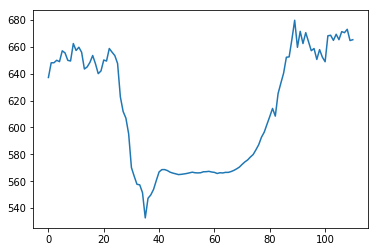

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/6/json5/2019-05-08-134050_000000000030_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/6/json5/2019-05-08-134050_000000000031_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/6/json5/2019-05-08-134050_000000000032_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/6/json5/2019-05-08-134050_000000000033_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/6/json5/2019-05-08-134050_000000000034_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/6/json5/2019-05-08-134050_000000000035_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/6/json5/2019-05-08-134050_000000000036_keypoints.json
/content/gdrive/My D

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/8/json4/2019-05-08-134101_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/8/json4/2019-05-08-134101_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/8/json4/2019-05-08-134101_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/8/json4/2019-05-08-134101_000000000024_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/8/json4/2019-05-08-134101_000000000025_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/8/json4/2019-05-08-134101_000000000026_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/8/json4/2019-05-08-134101_000000000027_keypoints.json
/content/gdrive/My D

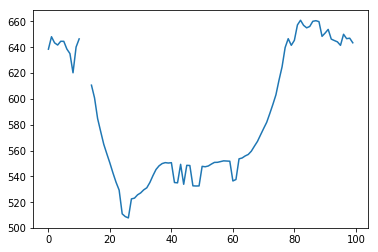

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/9/json3/2019-05-08-134109_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/9/json3/2019-05-08-134109_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/9/json3/2019-05-08-134109_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/9/json3/2019-05-08-134109_000000000024_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/9/json3/2019-05-08-134109_000000000025_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/9/json3/2019-05-08-134109_000000000026_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/9/json3/2019-05-08-134109_000000000027_keypoints.json
/content/gdrive/My D

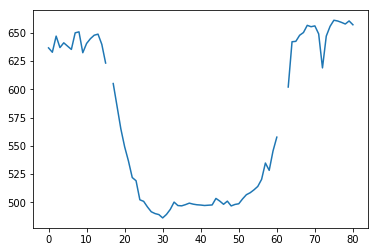

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/0/json2/2019-05-08-134130_000000000025_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/0/json2/2019-05-08-134130_000000000026_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/0/json2/2019-05-08-134130_000000000027_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/0/json2/2019-05-08-134130_000000000028_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/0/json2/2019-05-08-134130_000000000029_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/0/json2/2019-05-08-134130_000000000030_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/0/json2/2019-05-08-134130_000000000031_keypoints.json
/content/gdrive/My D

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7 (1)/json1/2019-05-08-134057_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7 (1)/json1/2019-05-08-134057_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7 (1)/json1/2019-05-08-134057_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7 (1)/json1/2019-05-08-134057_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7 (1)/json1/2019-05-08-134057_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7 (1)/json1/2019-05-08-134057_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7 (1)/json1/2019-05-08-134057_000000000024_keypoin

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5 (1)/json1/2019-05-10-121157_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5 (1)/json1/2019-05-10-121157_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5 (1)/json1/2019-05-10-121157_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5 (1)/json1/2019-05-10-121157_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5 (1)/json1/2019-05-10-121157_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5 (1)/json1/2019-05-10-121157_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5 (1)/json1/2019-05-10-121157_000000000017_keypoin

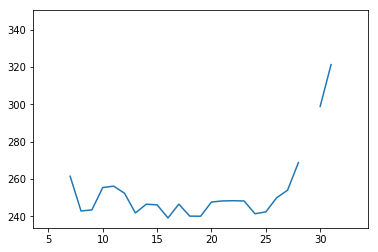

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/0/json1/0-2019-05-15-191758_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/0/json1/0-2019-05-15-191758_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/0/json1/0-2019-05-15-191758_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/0/json1/0-2019-05-15-191758_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/0/json1/0-2019-05-15-191758_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/0/json1/0-2019-05-15-191758_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/0/json1/0-2019-05-15-191758

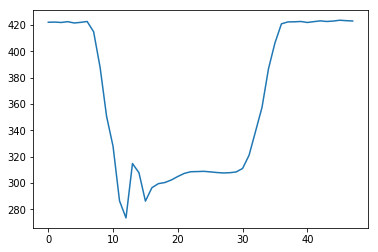

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/1/json1/1-2019-05-15-190348_000000000007_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/1/json1/1-2019-05-15-190348_000000000008_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/1/json1/1-2019-05-15-190348_000000000009_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/1/json1/1-2019-05-15-190348_000000000010_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/1/json1/1-2019-05-15-190348_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/1/json1/1-2019-05-15-190348_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/1/json1/1-2019-05-15-190348

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/6/json1/6-2019-05-15-190548_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/6/json1/6-2019-05-15-190548_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/6/json1/6-2019-05-15-190548_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/6/json1/6-2019-05-15-190548_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/6/json1/6-2019-05-15-190548_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/6/json1/6-2019-05-15-190548_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/6/json1/6-2019-05-15-190548

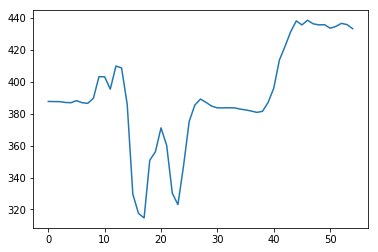

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/7/json1/7-2019-05-15-190658_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/7/json1/7-2019-05-15-190658_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/7/json1/7-2019-05-15-190658_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/7/json1/7-2019-05-15-190658_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/7/json1/7-2019-05-15-190658_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/7/json1/7-2019-05-15-190658_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/7/json1/7-2019-05-15-190658

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/8/json1/8-2019-05-15-190748_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/8/json1/8-2019-05-15-190748_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/8/json1/8-2019-05-15-190748_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/8/json1/8-2019-05-15-190748_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/8/json1/8-2019-05-15-190748_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/8/json1/8-2019-05-15-190748_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/8/json1/8-2019-05-15-190748

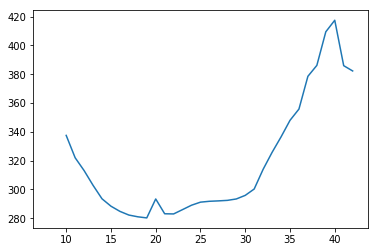

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/9/json1/9-2019-05-15-190932_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/9/json1/9-2019-05-15-190932_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/9/json1/9-2019-05-15-190932_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/9/json1/9-2019-05-15-190932_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/9/json1/9-2019-05-15-190932_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/9/json1/9-2019-05-15-190932_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/15-5/9/json1/9-2019-05-15-190932

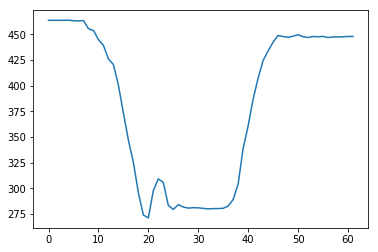

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/2/json2/2-2019-05-16-072327_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/2/json2/2-2019-05-16-072327_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/2/json2/2-2019-05-16-072327_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/2/json2/2-2019-05-16-072327_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/2/json2/2-2019-05-16-072327_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/2/json2/2-2019-05-16-072327_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/2/json

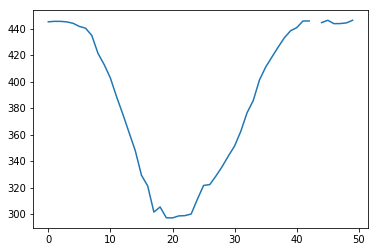

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/9/json3/9-2019-05-16-072700_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/9/json3/9-2019-05-16-072700_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/9/json3/9-2019-05-16-072700_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/9/json3/9-2019-05-16-072700_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/9/json3/9-2019-05-16-072700_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/9/json3/9-2019-05-16-072700_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/9/json

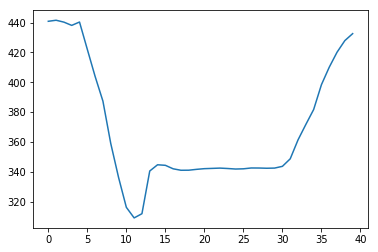

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/6/json4/6-2019-05-16-072538_000000000006_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/6/json4/6-2019-05-16-072538_000000000007_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/6/json4/6-2019-05-16-072538_000000000008_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/6/json4/6-2019-05-16-072538_000000000009_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/6/json4/6-2019-05-16-072538_000000000010_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/6/json4/6-2019-05-16-072538_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/6/json

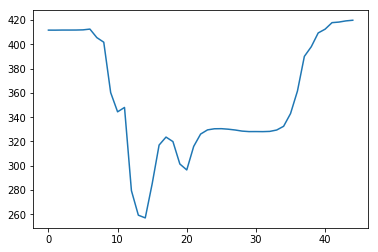

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/5/json5/5-2019-05-16-072512_000000000009_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/5/json5/5-2019-05-16-072512_000000000010_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/5/json5/5-2019-05-16-072512_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/5/json5/5-2019-05-16-072512_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/5/json5/5-2019-05-16-072512_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/5/json5/5-2019-05-16-072512_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/5/json

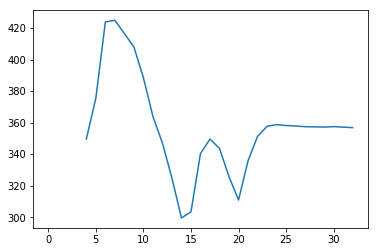

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/8/json6/8-2019-05-16-072613_000000000009_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/8/json6/8-2019-05-16-072613_000000000010_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/8/json6/8-2019-05-16-072613_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/8/json6/8-2019-05-16-072613_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/8/json6/8-2019-05-16-072613_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/8/json6/8-2019-05-16-072613_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/8/json

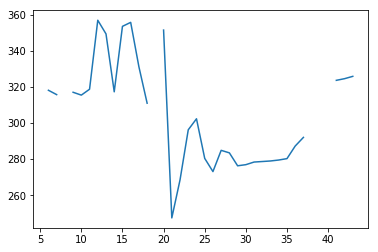

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/1/json7/1-2019-05-16-072357_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/1/json7/1-2019-05-16-072357_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/1/json7/1-2019-05-16-072357_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/1/json7/1-2019-05-16-072357_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/1/json7/1-2019-05-16-072357_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/1/json7/1-2019-05-16-072357_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/1/json

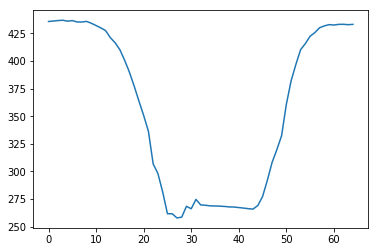

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/0/json8/0-2019-05-16-072737_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/0/json8/0-2019-05-16-072737_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/0/json8/0-2019-05-16-072737_000000000024_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/0/json8/0-2019-05-16-072737_000000000025_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/0/json8/0-2019-05-16-072737_000000000026_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/0/json8/0-2019-05-16-072737_000000000027_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/0/json

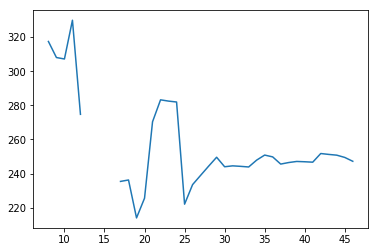

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/3/json9/3-2019-05-16-072427_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/3/json9/3-2019-05-16-072427_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/3/json9/3-2019-05-16-072427_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/3/json9/3-2019-05-16-072427_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/3/json9/3-2019-05-16-072427_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/3/json9/3-2019-05-16-072427_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/16-5-fm/3/json

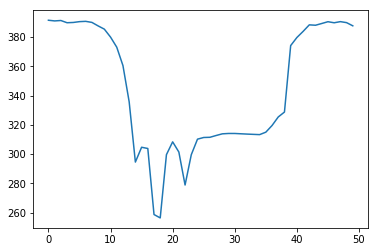

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/2/json2/2-2019-05-16-092301_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/2/json2/2-2019-05-16-092301_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/2/json2/2-2019-05-16-092301_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/2/json2/2-2019-05-16-092301_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/2/json2/2-2019-05-16-092301_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/2/json2/2-2019-05-16-092301_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/2/json2/2-2019-05-16-092301_000000000019_keypoints.json
/conte

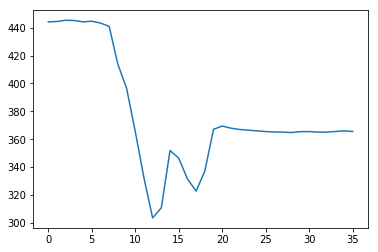

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7/json1/7-2019-05-16-072557_000000000007_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7/json1/7-2019-05-16-072557_000000000008_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7/json1/7-2019-05-16-072557_000000000009_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7/json1/7-2019-05-16-072557_000000000010_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7/json1/7-2019-05-16-072557_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7/json1/7-2019-05-16-072557_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/7/json1/7-2019-05-16-072557_000000000013_keypoints.json
/conte

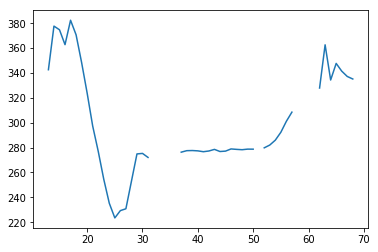

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/1/json1/1-2019-05-16-180525_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/1/json1/1-2019-05-16-180525_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/1/json1/1-2019-05-16-180525_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/1/json1/1-2019-05-16-180525_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/1/json1/1-2019-05-16-180525_000000000024_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/1/json1/1-2019-05-16-180525_000000000025_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/1/json1/1-2019-05-16-180525

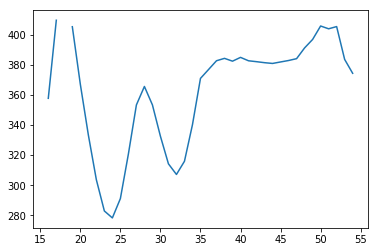

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/8/json2/8-2019-05-16-180831_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/8/json2/8-2019-05-16-180831_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/8/json2/8-2019-05-16-180831_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/8/json2/8-2019-05-16-180831_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/8/json2/8-2019-05-16-180831_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/8/json2/8-2019-05-16-180831_000000000024_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/8/json2/8-2019-05-16-180831

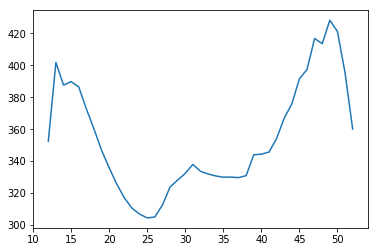

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/9/json3/9-2019-05-16-180901_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/9/json3/9-2019-05-16-180901_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/9/json3/9-2019-05-16-180901_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/9/json3/9-2019-05-16-180901_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/9/json3/9-2019-05-16-180901_000000000024_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/9/json3/9-2019-05-16-180901_000000000025_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/9/json3/9-2019-05-16-180901

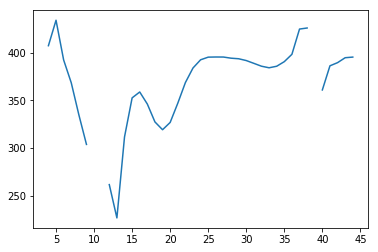

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/7/json4/7-2019-05-16-180811_000000000008_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/7/json4/7-2019-05-16-180811_000000000009_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/7/json4/7-2019-05-16-180811_000000000010_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/7/json4/7-2019-05-16-180811_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/7/json4/7-2019-05-16-180811_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/7/json4/7-2019-05-16-180811_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/7/json4/7-2019-05-16-180811

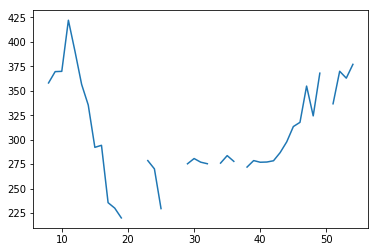

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/4/json6/4-2019-05-16-180657_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/4/json6/4-2019-05-16-180657_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/4/json6/4-2019-05-16-180657_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/4/json6/4-2019-05-16-180657_000000000017_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/4/json6/4-2019-05-16-180657_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/4/json6/4-2019-05-16-180657_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/4/json6/4-2019-05-16-180657

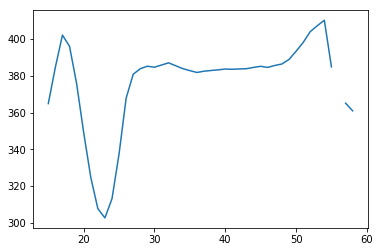

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/6/json7/6-2019-05-16-180750_000000000018_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/6/json7/6-2019-05-16-180750_000000000019_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/6/json7/6-2019-05-16-180750_000000000020_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/6/json7/6-2019-05-16-180750_000000000021_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/6/json7/6-2019-05-16-180750_000000000022_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/6/json7/6-2019-05-16-180750_000000000023_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/6/json7/6-2019-05-16-180750

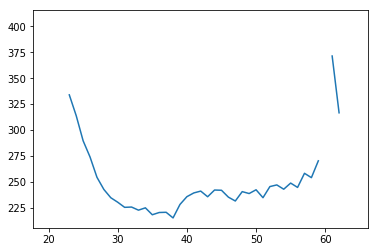

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/0/json8/0-2019-05-16-180922_000000000033_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/0/json8/0-2019-05-16-180922_000000000034_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/0/json8/0-2019-05-16-180922_000000000035_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/0/json8/0-2019-05-16-180922_000000000036_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/0/json8/0-2019-05-16-180922_000000000037_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/0/json8/0-2019-05-16-180922_000000000038_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/17-5/0/json8/0-2019-05-16-180922

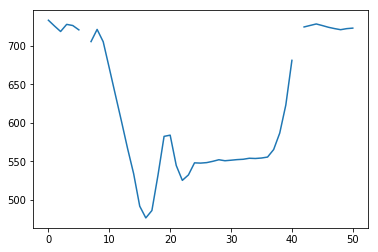

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5/json1/5-2019-05-10-121157_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5/json1/5-2019-05-10-121157_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5/json1/5-2019-05-10-121157_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5/json1/5-2019-05-10-121157_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5/json1/5-2019-05-10-121157_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5/json1/5-2019-05-10-121157_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/5/json1/5-2019-05-10-121157_000000000017_keypoints.json
/conte

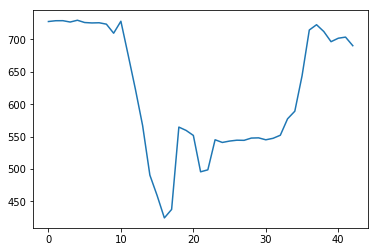

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4/json1/4-2019-05-10-121134_000000000011_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4/json1/4-2019-05-10-121134_000000000012_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4/json1/4-2019-05-10-121134_000000000013_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4/json1/4-2019-05-10-121134_000000000014_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4/json1/4-2019-05-10-121134_000000000015_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4/json1/4-2019-05-10-121134_000000000016_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/4/json1/4-2019-05-10-121134_000000000017_keypoints.json
/conte

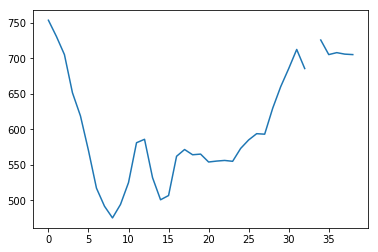

/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3/json1/3-2019-05-10-121113_000000000003_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3/json1/3-2019-05-10-121113_000000000004_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3/json1/3-2019-05-10-121113_000000000005_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3/json1/3-2019-05-10-121113_000000000006_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3/json1/3-2019-05-10-121113_000000000007_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3/json1/3-2019-05-10-121113_000000000008_keypoints.json
/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/3/json1/3-2019-05-10-121113_000000000009_keypoints.json
/conte

In [0]:
frames_offset = 5 # before and after best frame

def mean_pos(path):
  #print(path)
  with open(path) as f:
    data=json.load(f)['people'][0]['hand_right_keypoints_2d']
    #print( data['hand_right_keypoints_2d'][:17])
    
    def mean_pos( pos ): # 42 values for the hand (not including confid.score)
      pos = np.array (pos)
      # only y values, delete x
      pos = np.delete( pos, list(range(0, arr.shape[0], 2)))
      mask = pos > 1
      x = np.nanmean ( pos [mask])
      #if np.isnan(x):
      #  x = 0
      return x
    
    return mean_pos ( data)#['hand_right_keypoints_2d'])
    #r = mean_pos (data['hand_right_keypoints_2d'])  
    # l = mean_pos (data['hand_left_keypoints_2d'])
    # idea was to check which hand was highest,
    # but openpose seems to have high faulty values at times
    # returning the wrong hand as a result
    
    #print('right hand ', r)
    #print('left hand', l)
    #if r > l:
    #  return r
    #else:
    #  return l
    
  
def find_frame_with_sign(json_folder): # the frame with the highest hand is hopefully the sign
  json_files = glob.glob(f"{json_folder}/*.json")
  print(len(json_files), ' frames')
  #hand_data = np.zeros([len( json_files )])
  hand_data = 9999 # high number
  mean_list = np.zeros(len(json_files))
  best_frame_number = 0

  for j,json_file in enumerate(json_files):
    x = mean_pos(json_file)
    mean_list[j] = x
    #print('hand data ', x)
    if x < hand_data:
      #print(x)
      hand_data = x
      json_file_with_sign = json_file
      best_frame_number = j
      print('new best frame ', best_frame_number,' data: ', x)
  #plt.scatter(mean_list)
  plt.plot(mean_list)
  plt.show()
  return json_files[best_frame_number- frames_offset: best_frame_number+ frames_offset]
  #return json_file_with_sign
  

#json_folders = glob.glob(f"{base_dir}/**/json*/", recursive=True)
json_folders = glob.glob("/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/redan_kopierade_till_training/**/json*/", recursive=True)
#json_folders = glob.glob("/content/gdrive/My Drive/stud/dl-umu/lab2/not_used_img/**/json*/", recursive=True)
#json_folders = glob.glob("/content/gdrive/My Drive/stud/dl-umu/lab2/vid/**/json*/", recursive=True)
#json_folders = glob.glob("/content/gdrive/My Drive/stud/dl-umu/lab2/vid/**/json*/", recursive=True)

print(len(json_folders))
#hand_arr = np.zeros([len(json_folders), 42])
#hand_arr = np.zeros([len(json_folders), 21, 2])
hand_arr = np.zeros([len(json_folders), frames_offset *2, 21, 2])

#training_labels = np.zeros([len(json_folders)])
training_labels = np.full( (len(json_folders)), 22 ) # to get integers

for i,json_folder in enumerate(json_folders):
  #print(len(json_folders))
  print(i)
  print(json_folder)
  
  label = json_folder.split('/')[-3]
  if "(" in label:
    label = label[0:1]
  label = int(label) # label from directory name  
  
  paths = find_frame_with_sign(json_folder)
  for k, path in enumerate(paths):
    print(path)
    hand_origin = 0
    with open(path) as f:
      arr = load_hand(f)
      arr = arr.reshape(21,2)
      x, y = arr.T
      # plt.subplots()
      if False:
        plt.scatter(x,y)
        for index in range( arr.shape[0]):
          plt.annotate(index, (x[index], y[index]))

      # plot with all lines
      #plt.plot( x,y)
      #plt.show()

      #for index in range( arr.shape[0]):
      #plt.plot(x[0:4], y[0:4])
      #plt.plot( np.concatenate((x[:0], x[5:8])), np.concatenate((y[:0], y[5:8])))
      #plt.plot(np.concatenate((x[:0],x[9:12])), np.concatenate((y[:0], y[9:12])))
  #    plt.plot(x[15:20], y[15:20])

      # plot each finger. todo: could add 0:th element to each
      #plot_save_hand_only(x,y)



      #plt.imshow( arr)#, vmin=0, vmax=1)
      #plt.imshow(x,y)



    #print(arr.shape)
    hand_arr[i,k] = arr #.reshape(42,)
    training_labels[i] = label
    #print(data['hand_right_keypoints_2d'][0])
    #return data['hand_right_keypoints_2d'][0] # 63
print( hand_arr.shape)
print(training_labels.shape)

#### Functions
* Functions for finding the frame-number that probably contains the best image of the sign (highest hand position) 
* Functions for plotting hand positions


In [0]:
#print(training_labels)
#training_data = hand_arr

frames_offset = 5 # before and after best frame

def find_best_frame(sample, plot=False):
  #[np.argmin(frame) for frame[0] in sample]
  hand_root_positions = np.zeros(sample.shape[0])
  for i,frame in enumerate(sample):
    #print(frame)
    #if frame[1] > 1:
    hand_root_positions[i] = frame[1]
    
  #print('hand_root_positions ', hand_root_positions)
  #print(hand_root_positions.shape)
  b = hand_root_positions > 1
  hand_root_positions = hand_root_positions[b]
  #print(hand_root_positions.shape)
  if (plot):
    plt.plot(hand_root_positions)
    plt.show()
  return np.argmin(hand_root_positions)

def sample_slice_with_sign(sample, offset=frames_offset, padding=False):
  best_frame_num = find_best_frame(sample)
  start_frame, end_frame = best_frame_num - offset, best_frame_num + offset
  if start_frame < 0:
    if padding:
      print(start_frame, ' frames ', end_frame)
      end_frame = end_frame + (start_frame * -1)
      print(start_frame ,' frames ', end_frame)
    start_frame = 0
  return sample[start_frame : end_frame]
    
def sample_to_img(sample, save=False, only_frames_with_sign = True, out_dir=train_dir):
  #print(sample.shape)
  if only_frames_with_sign:
    sample_slice = sample_slice_with_sign(sample)
  else:
    sample_slice = sample
  
  #print('sample_slice: ', sample_slice.shape)
    
  for frame in sample_slice:
    if np.sum(frame) > 1:#0 not in frame: # # drop frames with zero values
      #print(frame)
      frame = frame.reshape(21,2)    
      x, y = frame.T
      plt.plot(x,y, alpha=0.7)    

  if (save):
    directory = f"{out_dir}{training_labels[i]}/"
    print('dir to save to: ', directory)
    if not os.path.exists(directory):
      os.makedirs(directory)
    plt.axis('off')
    name=int( round(time.time() *100000)) 
    res=plt.savefig(f"{directory}{training_labels[i]}-{name}-{i}.jpg", bbox_inches='tight')
    print(res)
  plt.show()
  print('Label: ', training_labels[i])
  print('i: ', i)

  
# not used, skips unrealistic lines like between fingertip and next finger.
def save_hand_only(x,y,save=False): 
  plt.plot(x[0:4], y[0:4])
  plt.plot(x[5:8], y[5:8])
  plt.plot(x[9:12], y[9:12])
  plt.plot(x[13:16], y[13:16])
  plt.plot(x[17:20], y[17:20])
  plt.axis('off')
  if save:
    directory = f"{train_dir}{label}/"
    print('dir to save to: ', directory)
    if not os.path.exists(directory):
      os.makedirs(directory)
    x=int( round(time.time() *100000)) 
    res=plt.savefig(f"{directory}{i}-{k}-{x}.jpg", bbox_inches='tight')
    print(res)
  plt.show()  

### Plot an illustrative image of each sample

#### Plot the x,y values of the positions of the hand.
While it looks expressive it also may also be too much, I gather the not so important frames before and after the sign do not add alot of value. 

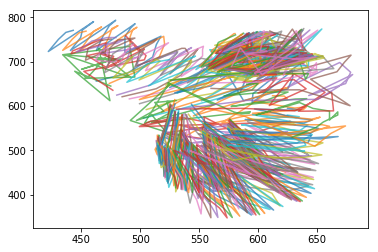

Label:  3
i:  0


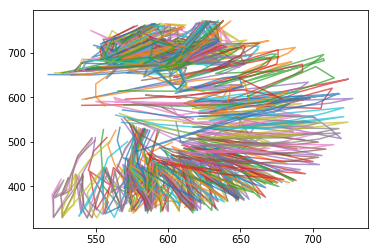

Label:  4
i:  1


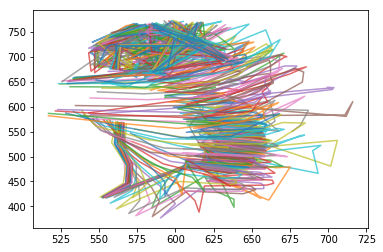

Label:  6
i:  2


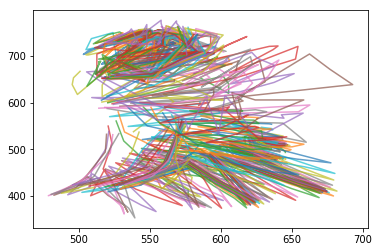

Label:  8
i:  3


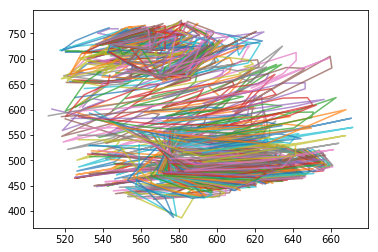

Label:  9
i:  4


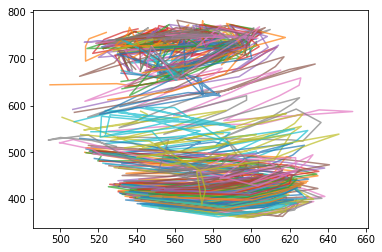

Label:  0
i:  5


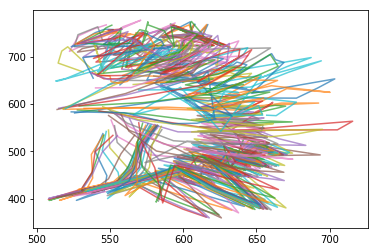

Label:  7
i:  6


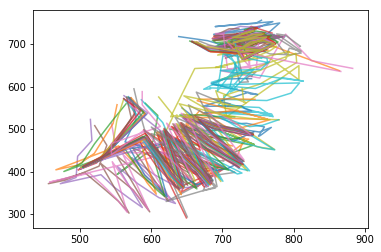

Label:  5
i:  7


Label:  0
i:  8


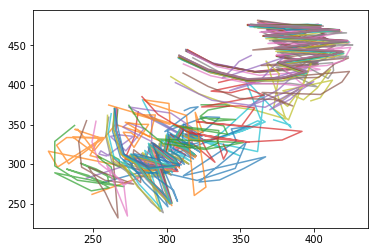

Label:  1
i:  9


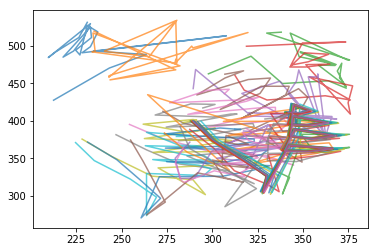

Label:  6
i:  10


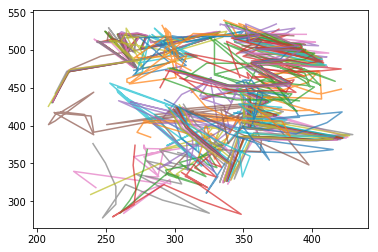

Label:  7
i:  11


In [0]:
for i, sample in enumerate(training_data[0:12]):
  sample_to_img(sample, False, False)

####Select frames containing the sign
To make the data more concise / more clear, select the frame with the highest position of the hand (should contain the sign) and plot the frames around that.

(150,)
(97,)


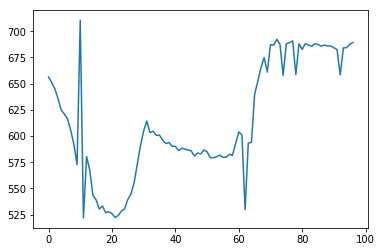

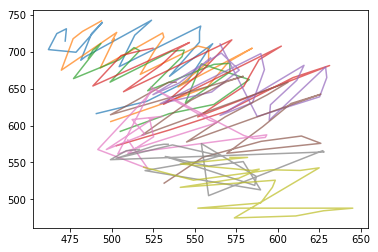

Label:  3
i:  0
(150,)
(113,)


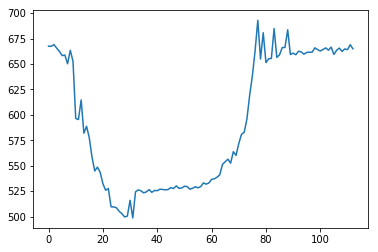

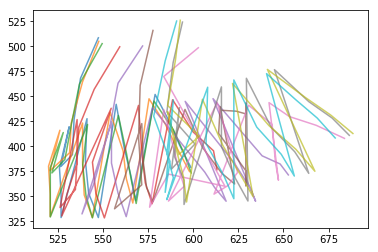

Label:  4
i:  1
(150,)
(111,)


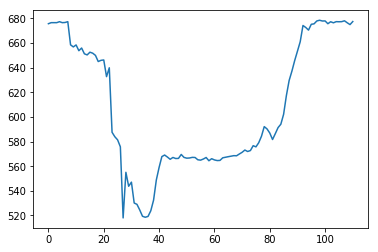

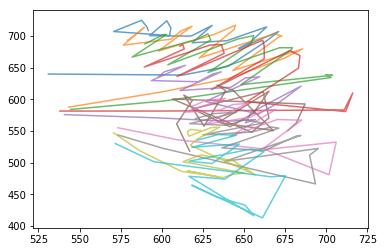

Label:  6
i:  2
(150,)
(95,)


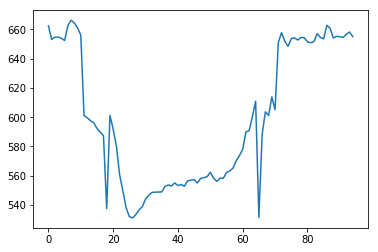

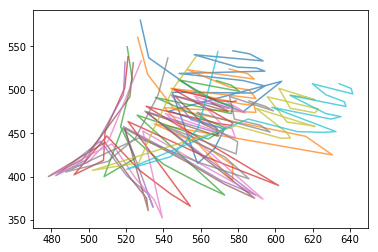

Label:  8
i:  3
(150,)
(98,)


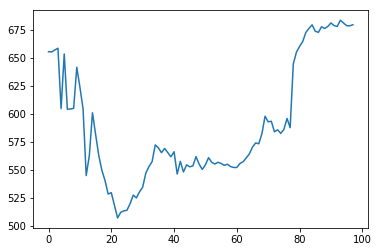

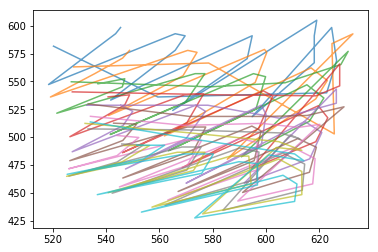

Label:  9
i:  4
(150,)
(78,)


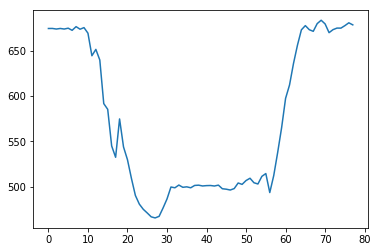

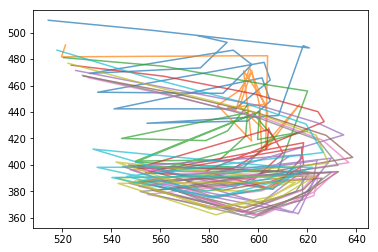

Label:  0
i:  5
(150,)
(75,)


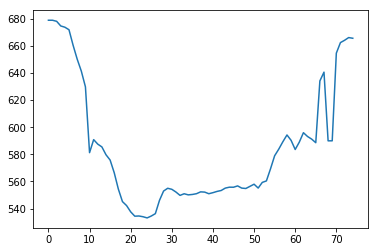

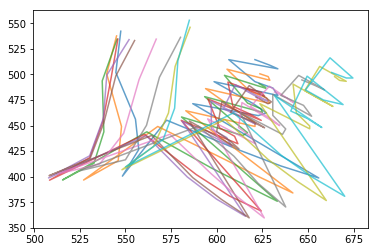

Label:  7
i:  6
(150,)
(49,)


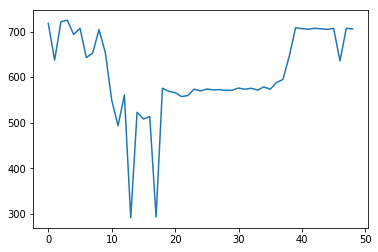

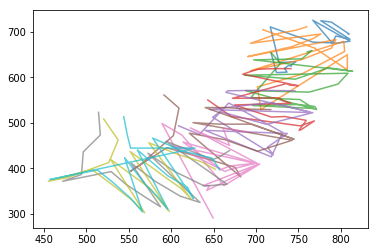

Label:  5
i:  7
(150,)
(26,)


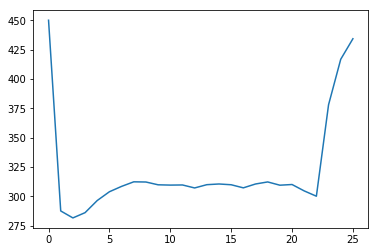

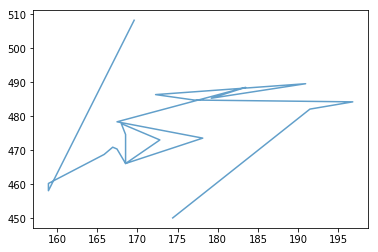

Label:  0
i:  8
(150,)
(48,)


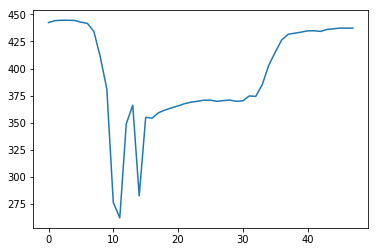

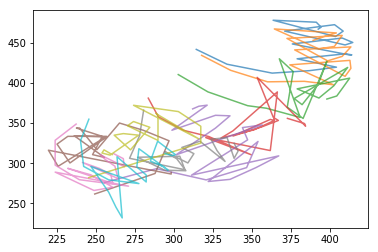

Label:  1
i:  9
(150,)
(35,)


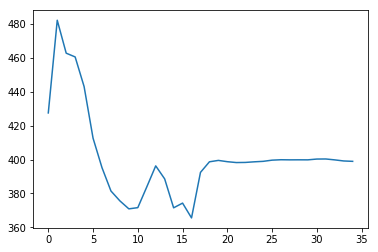

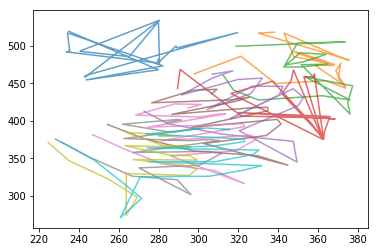

Label:  6
i:  10
(150,)
(55,)


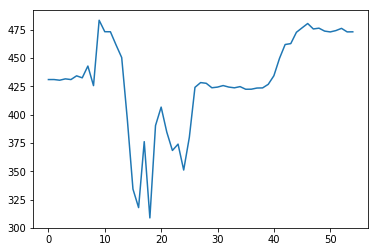

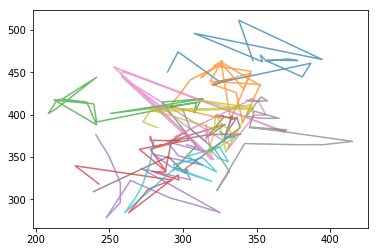

Label:  7
i:  11


In [0]:
for i, sample in enumerate(training_data[:12]):
  sample_to_img(sample, False, True)

## Preprocessing
Select only the frames containing the sign and store them in a seperate array so you can try models on both all frames and only selected frames.

In [0]:
training_data_selected_frames = np.zeros((training_data.shape[0],frames_offset*2,training_data.shape[2])) #np.zeros_like(training_data)
for i, sample in enumerate(training_data):
  training_data_selected_frames[i] = sample_slice_with_sign(sample,frames_offset,True)

-1  frames  9
-1  frames  10
-3  frames  7
-3  frames  10


# Training
Training on data from openpose. The data is loaded from json-files containing positions of detected bodyparts.

##Simple model using Logistic regression
Simple model using RMSprop() as optimizer and mae as loss function.

In [0]:
#training_data = hand_arr
def train_simple_model(training_data):
  print('shape training_data ', training_data.shape)
  from tensorflow.keras.models import Sequential
  from keras import layers
  from keras.optimizers import RMSprop
  model = keras.Sequential()
  model.add(keras.layers.Flatten())#input_shape=(lookback // step, float_data.shape[-1])))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add(keras.layers.Dense(10))
  model.compile(optimizer=keras.optimizers.RMSprop(), loss='mae',metrics=['accuracy'])
  history = model.fit(training_data,training_labels,epochs=150,validation_split=0.2)

In [0]:
train_simple_model(training_data)

shape training_data  (54, 150, 42)
Train on 43 samples, validate on 11 samples
Epoch 1/150
43/43 [==============================] - 0s 5ms/sample - loss: 1986.5834 - accuracy: 0.1860 - val_loss: 1808.2638 - val_accuracy: 0.0000e+00
Epoch 2/150
43/43 [==============================] - 0s 991us/sample - loss: 1813.8280 - accuracy: 0.0000e+00 - val_loss: 1061.9388 - val_accuracy: 0.0000e+00
Epoch 3/150
43/43 [==============================] - 0s 855us/sample - loss: 979.0884 - accuracy: 0.0000e+00 - val_loss: 629.3457 - val_accuracy: 0.5455
Epoch 4/150
43/43 [==============================] - 0s 900us/sample - loss: 697.1752 - accuracy: 0.4186 - val_loss: 483.3970 - val_accuracy: 0.0000e+00
Epoch 5/150
43/43 [==============================] - 0s 902us/sample - loss: 448.9136 - accuracy: 0.0000e+00 - val_loss: 395.9990 - val_accuracy: 0.0000e+00
Epoch 6/150
43/43 [==============================] - 0s 1000us/sample - loss: 455.9918 - accuracy: 0.1395 - val_loss: 208.2085 - val_accuracy: 0.0

In [0]:
train_simple_model(training_data_selected_frames)

-3  frames  7
-3  frames  10
shape training_data  (34, 10, 42)
Train on 27 samples, validate on 7 samples
Epoch 1/150
27/27 [==============================] - 0s 5ms/sample - loss: 364.0131 - accuracy: 0.0370 - val_loss: 720.7669 - val_accuracy: 0.0000e+00
Epoch 2/150
27/27 [==============================] - 0s 244us/sample - loss: 802.0559 - accuracy: 0.0000e+00 - val_loss: 162.9733 - val_accuracy: 0.0000e+00
Epoch 3/150
27/27 [==============================] - 0s 281us/sample - loss: 173.9300 - accuracy: 0.0000e+00 - val_loss: 300.5620 - val_accuracy: 0.0000e+00
Epoch 4/150
27/27 [==============================] - 0s 305us/sample - loss: 351.3730 - accuracy: 0.0000e+00 - val_loss: 167.5940 - val_accuracy: 0.0000e+00
Epoch 5/150
27/27 [==============================] - 0s 345us/sample - loss: 184.2040 - accuracy: 0.0000e+00 - val_loss: 257.3055 - val_accuracy: 0.0000e+00
Epoch 6/150
27/27 [==============================] - 0s 264us/sample - loss: 291.4318 - accuracy: 0.0000e+00 - val_

##Model using Conv1D


In [0]:
# add dim if conv2d
#training_data = training_data.reshape(training_data.shape[0],\
#                                      training_data.shape[1],training_data.shape[2],1)
def train_conv1d(training_data):
  print(training_data.shape)
  #training_data = training_data.reshape(training_data.shape[0],training_data.shape[1],training_data.shape[2]*training_data.shape[3])
  model = keras.Sequential()
  # model = models.Sequential()
  #model.add(keras.layers.Dense(32, activation='relu', input_shape=(150, int(411-411/3))))
  #model.add( keras.layers.Conv2D(filters=512, kernel_size=2, activation='relu') )#, input_shape=(150, int(411-411/3),1)))
  #model.add( keras.layers.Conv1D(filters=64, kernel_size=2, strides=1, activation='relu'))#, input_shape=(21, 2))) #input_shape=(150, 411))) #int(411-411/3))))
  model.add(keras.layers.Conv1D(filters=256, kernel_size=9, activation='relu'))
  model.add(keras.layers.MaxPooling1D(5))
  model.add(keras.layers.Conv1D(filters=256, kernel_size=9, activation='relu'))
  model.add(keras.layers.MaxPooling1D(5))
  model.add(keras.layers.Dense(256, activation='relu'))
  model.add( keras.layers.Flatten()) # must flatten before softmax
  model.add(keras.layers.Dense(10, activation='softmax'))

  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
  history = model.fit( training_data, training_labels, epochs=30)# batch_size=1)
  #validation_data=(x_val, y_v
  

In [0]:
train_conv1d(training_data)

(54, 150, 42)
Train on 54 samples
Epoch 1/30
54/54 [==============================] - 0s 8ms/sample - loss: 14.4282 - accuracy: 0.0926
Epoch 2/30
54/54 [==============================] - 0s 3ms/sample - loss: 14.6257 - accuracy: 0.0926
Epoch 3/30
54/54 [==============================] - 0s 3ms/sample - loss: 14.6257 - accuracy: 0.0926
Epoch 4/30
54/54 [==============================] - 0s 4ms/sample - loss: 14.6257 - accuracy: 0.0926
Epoch 5/30
54/54 [==============================] - 0s 4ms/sample - loss: 14.6257 - accuracy: 0.0926
Epoch 6/30
54/54 [==============================] - 0s 4ms/sample - loss: 14.6257 - accuracy: 0.0926
Epoch 7/30
54/54 [==============================] - 0s 5ms/sample - loss: 14.6257 - accuracy: 0.0926
Epoch 8/30
54/54 [==============================] - 0s 5ms/sample - loss: 14.6257 - accuracy: 0.0926
Epoch 9/30
54/54 [==============================] - 0s 5ms/sample - loss: 14.6257 - accuracy: 0.0926
Epoch 10/30
54/54 [==============================] - 0s 5

In [0]:
train_conv1d(training_data_selected_frames)

(34, 150, 42)
Train on 34 samples
Epoch 1/30
34/34 [==============================] - 0s 9ms/sample - loss: 14.1678 - accuracy: 0.1176
Epoch 2/30
34/34 [==============================] - 0s 5ms/sample - loss: 14.6959 - accuracy: 0.0882
Epoch 3/30
34/34 [==============================] - 0s 5ms/sample - loss: 14.2218 - accuracy: 0.1176
Epoch 4/30
34/34 [==============================] - 0s 3ms/sample - loss: 14.2218 - accuracy: 0.1176
Epoch 5/30
34/34 [==============================] - 0s 4ms/sample - loss: 14.2218 - accuracy: 0.1176
Epoch 6/30
34/34 [==============================] - 0s 4ms/sample - loss: 14.2218 - accuracy: 0.1176
Epoch 7/30
34/34 [==============================] - 0s 4ms/sample - loss: 14.2218 - accuracy: 0.1176
Epoch 8/30
34/34 [==============================] - 0s 4ms/sample - loss: 14.2218 - accuracy: 0.1176
Epoch 9/30
34/34 [==============================] - 0s 4ms/sample - loss: 14.2218 - accuracy: 0.1176
Epoch 10/30
34/34 [==============================] - 0s 4

##Model using GRU

In [0]:
# try with gru and rms
def train_gru(training_data):
  model = keras.Sequential()
  #from tensorflow.keras.layers import Embedding,LSTM

  # check correct dims, not [x,y] in last dim
  training_data = training_data.reshape(training_data.shape[0],\
                                        training_data.shape[1],42)
  print(training_data.shape)

  model.add(keras.layers.GRU(32,return_sequences=True, input_shape=(training_data.shape[1],42)))
  model.add(keras.layers.GRU(32, input_shape=(training_data.shape[1],42)))
  #model.add(keras.layers.GRU(32, activation='relu'))

  model.add(keras.layers.Dense(256))
  #model.add(keras.layers.Dense(10, activation=tf.nn.softmax))
  model.compile(optimizer=keras.optimizers.RMSprop(), loss='mae') #loss='sparse_categorical_crossentropy'
  history = model.fit( training_data, training_labels, epochs=150, validation_split=0.25)
  print(history.history.keys())
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])

(54, 150, 42)
Train on 40 samples, validate on 14 samples
Epoch 1/150
40/40 [==============================] - 2s 42ms/sample - loss: 4.8496 - val_loss: 4.2091
Epoch 2/150
40/40 [==============================] - 0s 9ms/sample - loss: 4.8433 - val_loss: 4.2001
Epoch 3/150
40/40 [==============================] - 0s 9ms/sample - loss: 4.8326 - val_loss: 4.1841
Epoch 4/150
40/40 [==============================] - 0s 9ms/sample - loss: 4.8143 - val_loss: 4.1589
Epoch 5/150
40/40 [==============================] - 0s 9ms/sample - loss: 4.7847 - val_loss: 4.1138
Epoch 6/150
40/40 [==============================] - 0s 9ms/sample - loss: 4.7263 - val_loss: 4.0121
Epoch 7/150
40/40 [==============================] - 0s 9ms/sample - loss: 4.6177 - val_loss: 3.8900
Epoch 8/150
40/40 [==============================] - 0s 8ms/sample - loss: 4.4618 - val_loss: 3.6460
Epoch 9/150
40/40 [==============================] - 0s 8ms/sample - loss: 4.1830 - val_loss: 3.4028
Epoch 10/150
40/40 [============

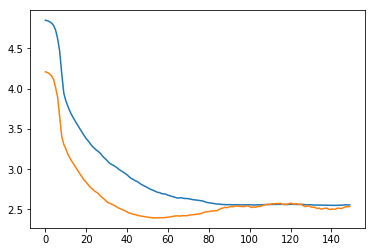

In [0]:
train_gru(training_data)

(54, 10, 42)
Train on 40 samples, validate on 14 samples
Epoch 1/150
40/40 [==============================] - 1s 37ms/sample - loss: 4.8526 - val_loss: 4.1643
Epoch 2/150
40/40 [==============================] - 0s 1ms/sample - loss: 4.7845 - val_loss: 4.1107
Epoch 3/150
40/40 [==============================] - 0s 955us/sample - loss: 4.7164 - val_loss: 4.0507
Epoch 4/150
40/40 [==============================] - 0s 925us/sample - loss: 4.6457 - val_loss: 3.9808
Epoch 5/150
40/40 [==============================] - 0s 913us/sample - loss: 4.5679 - val_loss: 3.9227
Epoch 6/150
40/40 [==============================] - 0s 943us/sample - loss: 4.5021 - val_loss: 3.8665
Epoch 7/150
40/40 [==============================] - 0s 1ms/sample - loss: 4.4359 - val_loss: 3.7976
Epoch 8/150
40/40 [==============================] - 0s 1ms/sample - loss: 4.3637 - val_loss: 3.7365
Epoch 9/150
40/40 [==============================] - 0s 1ms/sample - loss: 4.2988 - val_loss: 3.6717
Epoch 10/150
40/40 [=====

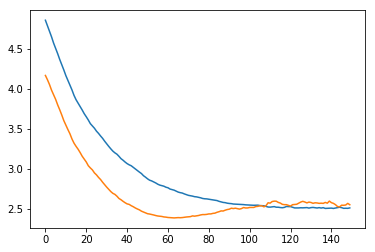

In [0]:
train_gru(training_data_selected_frames)

## Results
The only model that manages to learn sometihg is the one with GRU.

# 2. Use composite image generated from openpose-movies.
## Generate an image that hopefully describes the sign shown in the movie-clip. Use these generated images along with data-augmentation and pretrained models to train a model that can classify 0-9 in the swedish sign-language.



## Create the model
Trying two approaches to using a pretrained model. Finetune the last layers or not.

By plotting the layer activations I discovered that the sizes in the trainable layers were too small. So I increased the input image size.

In [0]:
def create_pretrained_model(fine_tune = True):
  conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3)) #, input_shape=(150, 150, 3)) # min size is 32, better to use that.
    # with small size, lousy results
  pretrained_model = models.Sequential()
  pretrained_model.add(conv_base) # error here if keras.models.Sequential() on previous line..?

  # fine-tuning by training the last layers of vgg16
  # from "Listing 5.22 Freezing all layers up to a specific one"
  if fine_tune:
    conv_base.trainable = True
    set_trainable = False
    for layer in conv_base.layers:
      #print(layer.name)
      if layer.name == 'block4_conv1':
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False

    pretrained_model.add(layers.Flatten())
    #pretrained_model.add( layers.Dense(256, activation='relu'))
    pretrained_model.add(layers.Dense(10, activation=tf.nn.softmax))

  #optimizers.RMSprop(lr=1e-5),

    pretrained_model.compile( 
      #optimizer=keras.optimizers.Adam( lr=0.001),
      #optimizer=keras.optimizers.RMSprop(lr=1e-5),
      optimizer='adam',
      loss='categorical_crossentropy',metrics=['accuracy'] )

  else:
    # model that freezes vgg16 and adds layers on top
    #pretrained_model.add( keras.layers.Conv2D(filters=64, kernel_size=2, strides=1,padding='same', activation='relu')) #input_shape=(28,28,1)))
    pretrained_model.add(layers.Flatten())
    pretrained_model.add( layers.Dense(256, activation='relu'))
    pretrained_model.add(layers.Dense(10, activation=tf.nn.softmax)) # softmax classifier for the 10 classes 0-9
    #pretrained_model.summary()

    print('trainable weights before freezing: ', len(pretrained_model.trainable_weights))
    conv_base.trainable = False
    print('trainable weights after freezing the conv_base: ', len(pretrained_model.trainable_weights))
    # sparse_
    pretrained_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
  print( '\n\nHela modellen: ')
  pretrained_model.summary()

  print( '\n\nFörtränade modellen: ')
  pretrained_model.layers[0].summary()

## Training

####Function for training on images in a directory

In [0]:
# a composite image of each move is composed with a secret recipe
# run training on these, augment since there is so little data
# todo: add validation data in own-folder. pass it to fit?

#train_dir = "/content/gdrive/My Drive/stud/dl-umu/lab2/not_used_img"
#test_dir = f"{base_dir}data/test/"

def train_on_images( train_dir ):
  checkpointer = ModelCheckpoint(filepath=f"{base_dir}_best-pretrained.hdf5", verbose = 1, save_best_only=True )

  validation_split = 0.25

  image_gen_train = ImageDataGenerator(
                                 validation_split= validation_split,
                                 rotation_range=15,
                                 horizontal_flip=True,
                                 vertical_flip=False,
                                 fill_mode='reflect',
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 shear_range=0.3,
                                 zoom_range=0.1,
                                 data_format='channels_last',
                                 rescale=1./255
                                )


  image_gen_val = ImageDataGenerator(rescale=1./255, validation_split= validation_split)

  train_generator = image_gen_train.flow_from_directory(
          train_dir,
          #color_mode='grayscale',
          target_size=(img_size, img_size),#same as input shape in conv_base
          batch_size=32,
          class_mode='categorical',
          subset='training')

  #https://stackoverflow.com/questions/38000336/how-to-get-labels-ids-in-keras-when-training-on-multiple-classes
  #inspect classes
  class_dictionary = train_generator.class_indices
  print('class_dictionary ', class_dictionary)

  val_gen = image_gen_val.flow_from_directory(
          train_dir,
          #color_mode='grayscale',
          target_size=(img_size, img_size),
      #    batch_size=1,
          class_mode='categorical',
          subset='validation')


  history = pretrained_model.fit_generator(
          train_generator,
          steps_per_epoch=10,
          callbacks=[checkpointer], # bug: https://github.com/tensorflow/tensorflow/issues/27688
          verbose=1,
          epochs=10,
          validation_data = val_gen)
  #        validation_steps = 1)

  # validation_data=val_gen(val_gen_batch_size ), validation_steps= validation_images.shape[0] // val_gen_batch_size

  # https://github.com/keras-team/keras/issues/3900
  # 
  # Plot training & validation accuracy values

  print(history.history.keys())
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy']) #acc for tf1?
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')
  plt.savefig(f"{base_dir}_acc.jpg", bbox_inches='tight')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper left')

  plt.savefig(f"{base_dir}_loss.jpg", bbox_inches='tight')  
  #print('file probably saved to: ' + base_dir)

  plt.show()


  # modelplot_filename = f"{int( round(time.time() *100000))}_model.png"
  # plot_model(pretrained_model, to_file=f"{base_dir}{modelplot_filename}") # save graph to file
  #SVG(model_to_dot( pretrained_model).create(prog='dot', format='svg'))

###Train with images generated by processing the movies generated by openpose.



Hela modellen: 
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                414730    
Total params: 15,129,418
Trainable params: 13,393,930
Non-trainable params: 1,735,488
_________________________________________________________________


Förtränade modellen: 
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 3

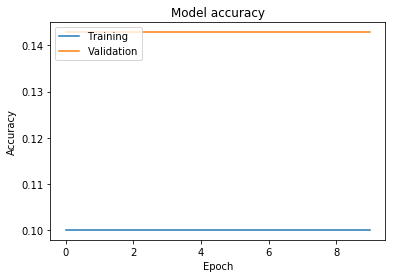

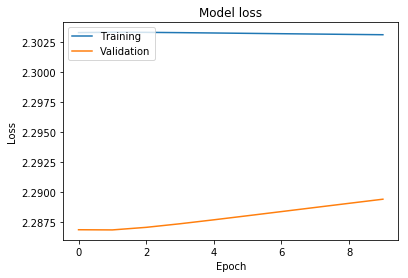

In [0]:
create_pretrained_model(True)
train_on_images(f"{base_dir}data/train-1/") # images generated with imagemagick

###Train with images generated from json-data from openpose

####Generate images from json-data

dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/0/
None


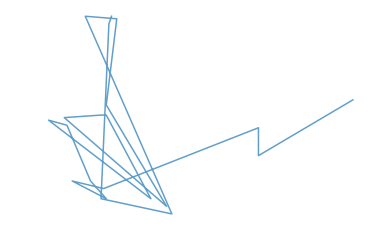

Label:  0
i:  0
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/0/
None


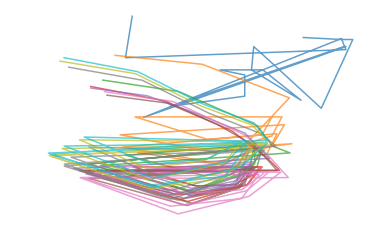

Label:  0
i:  1
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/1/
None


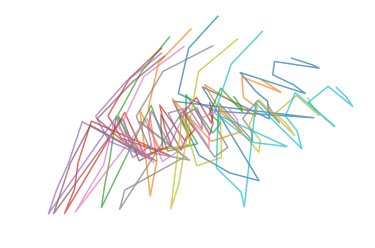

Label:  1
i:  2
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/1/
None


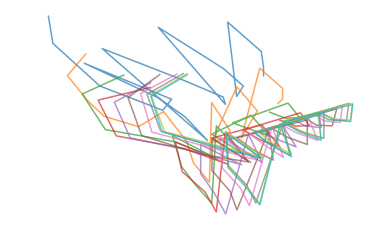

Label:  1
i:  3
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/2/
None


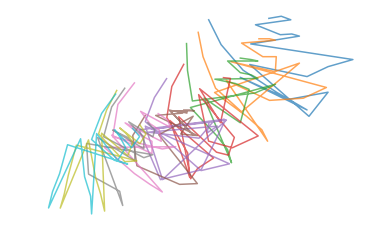

Label:  2
i:  4
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/2/
None


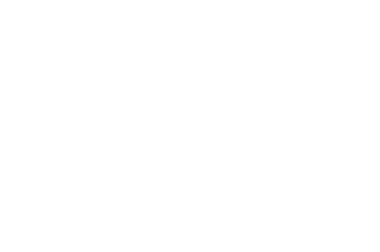

Label:  2
i:  5
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/3/
None


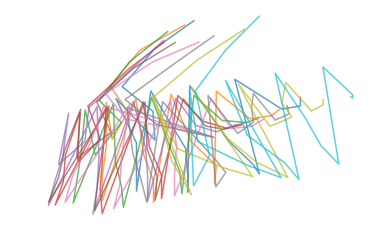

Label:  3
i:  6
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/3/
None


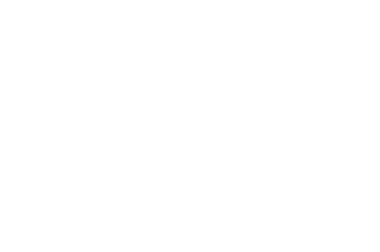

Label:  3
i:  7
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/4/
None


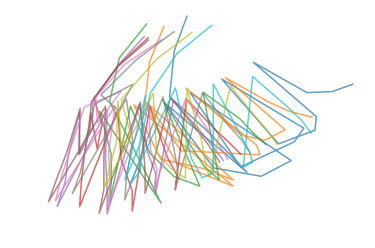

Label:  4
i:  8
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/4/
None


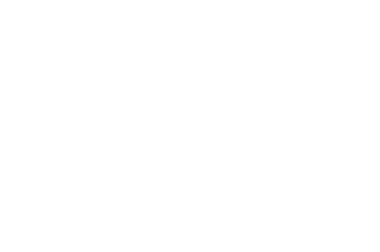

Label:  4
i:  9
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/5/
None


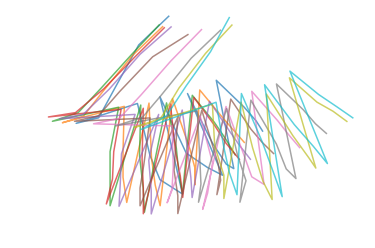

Label:  5
i:  10
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/5/
None


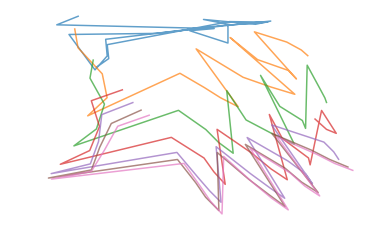

Label:  5
i:  11
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/6/
None


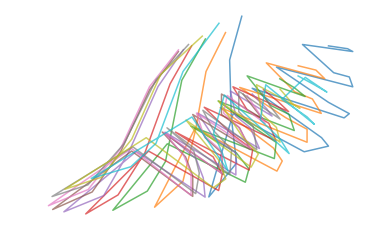

Label:  6
i:  12
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/6/
None


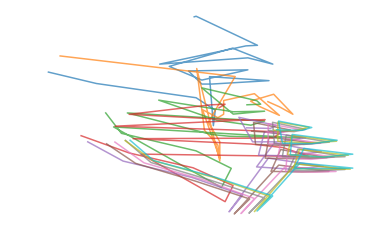

Label:  6
i:  13
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/7/
None


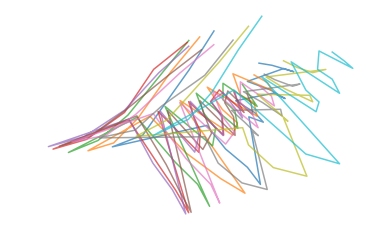

Label:  7
i:  14
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/7/
None


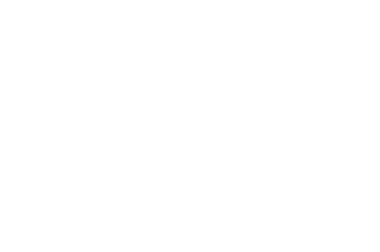

Label:  7
i:  15
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/8/
None


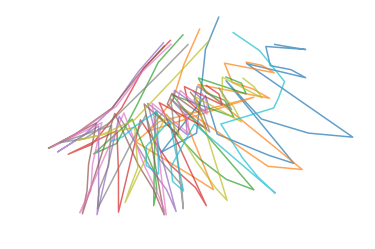

Label:  8
i:  16
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/8/
None


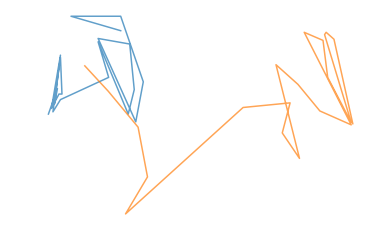

Label:  8
i:  17
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/9/
None


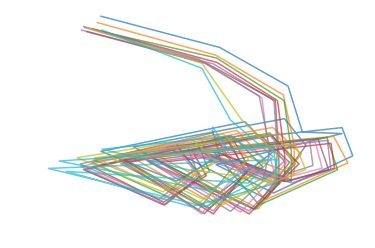

Label:  9
i:  18
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/9/
None


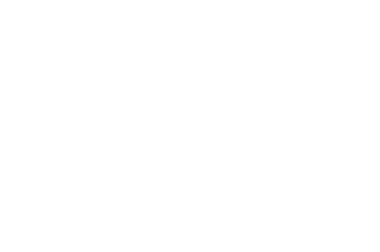

Label:  9
i:  19
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/3/
None


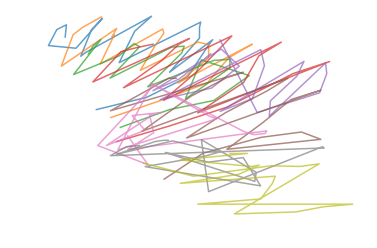

Label:  3
i:  20
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/4/
None


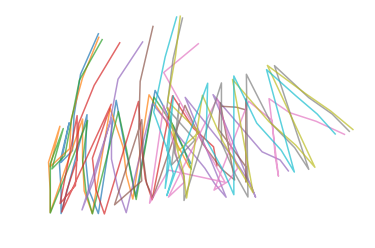

Label:  4
i:  21
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/6/
None


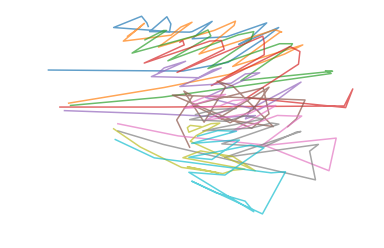

Label:  6
i:  22
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/8/
None


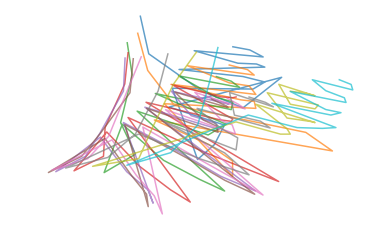

Label:  8
i:  23
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/9/
None


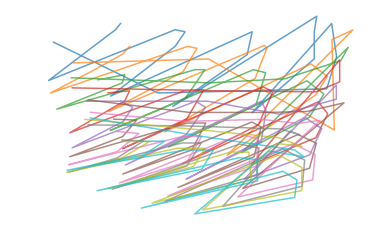

Label:  9
i:  24
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/0/
None


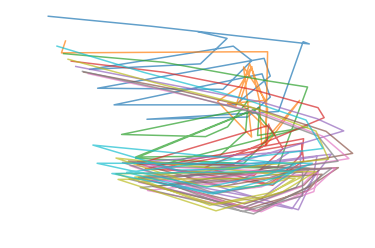

Label:  0
i:  25
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/7/
None


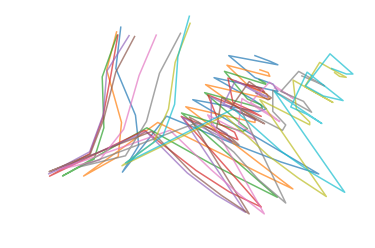

Label:  7
i:  26
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/5/
None


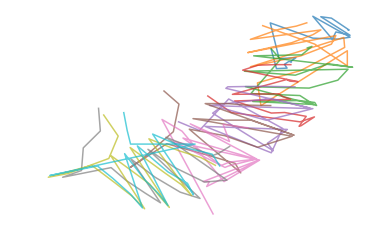

Label:  5
i:  27
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/0/
None


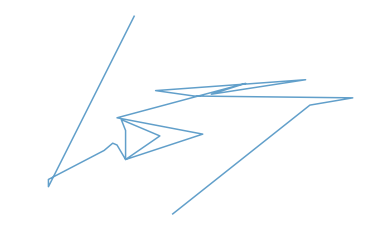

Label:  0
i:  28
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/1/
None


Label:  1
i:  29
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/6/
None


Label:  6
i:  30
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/7/
None


Label:  7
i:  31
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/8/
None


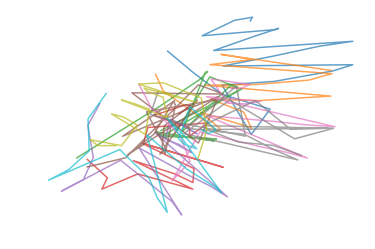

Label:  8
i:  32
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/9/
None


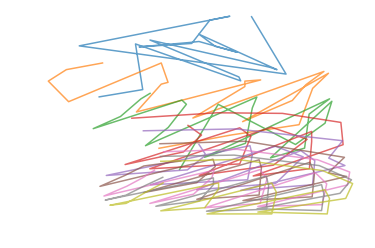

Label:  9
i:  33
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/2/
None


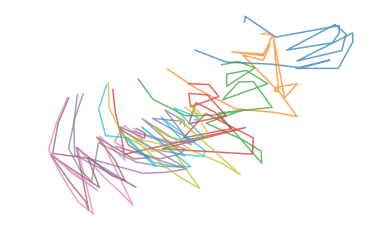

Label:  2
i:  34
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/9/
None


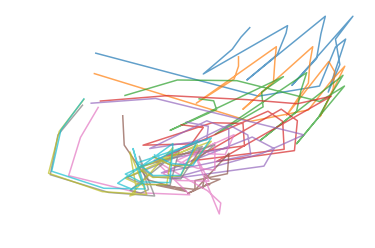

Label:  9
i:  35
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/6/
None


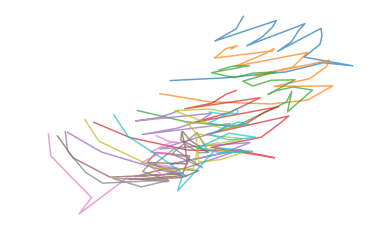

Label:  6
i:  36
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/5/
None


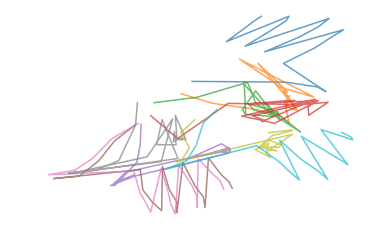

Label:  5
i:  37
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/8/
None


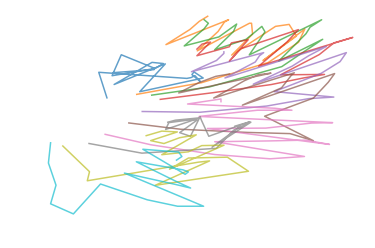

Label:  8
i:  38
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/1/
None


Label:  1
i:  39
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/0/
None


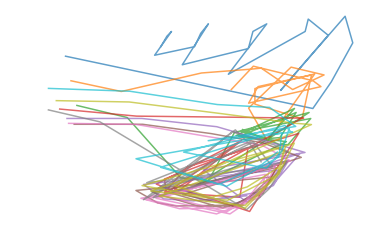

Label:  0
i:  40
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/3/
None


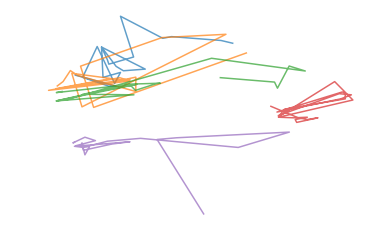

Label:  3
i:  41
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/2/
None


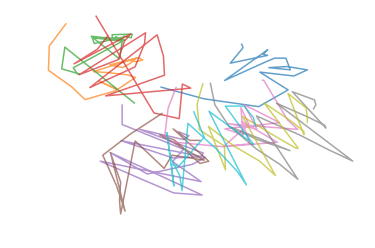

Label:  2
i:  42
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/7/
None


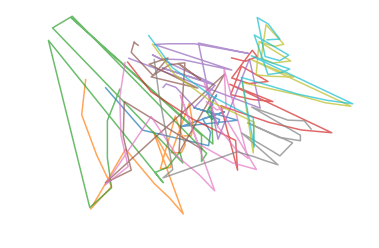

Label:  7
i:  43
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/1/
None


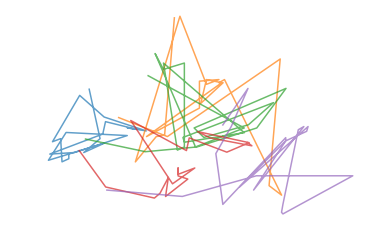

Label:  1
i:  44
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/8/
None


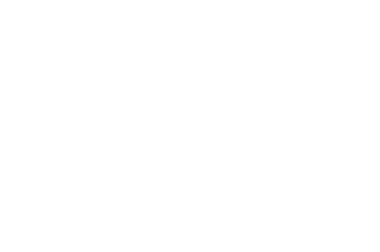

Label:  8
i:  45
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/9/
None


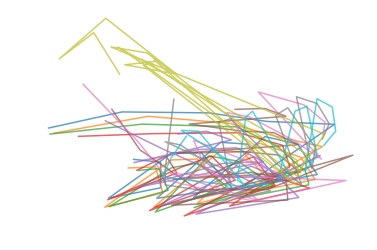

Label:  9
i:  46
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/7/
None


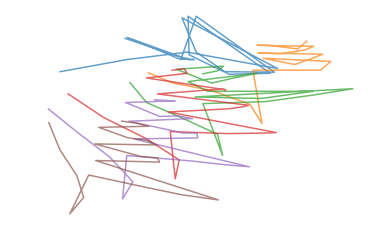

Label:  7
i:  47
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/4/
None


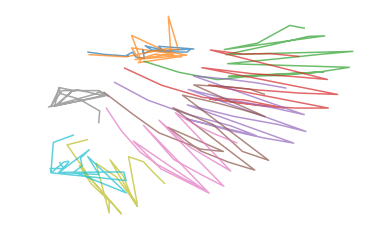

Label:  4
i:  48
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/6/
None


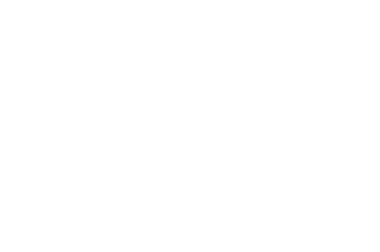

Label:  6
i:  49
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/0/
None


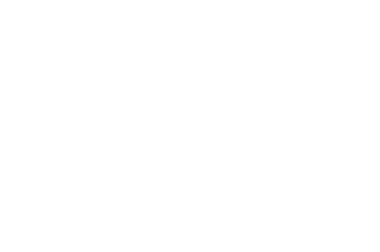

Label:  0
i:  50
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/5/
None


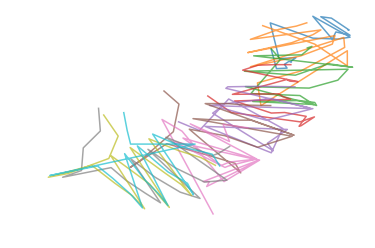

Label:  5
i:  51
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/4/
None


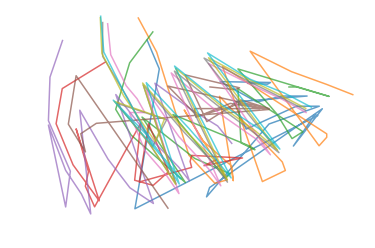

Label:  4
i:  52
dir to save to:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/train-2/3/
None


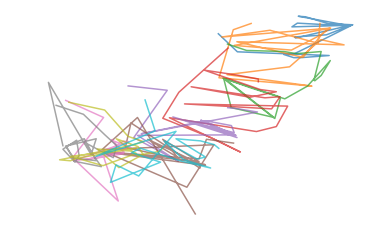

Label:  3
i:  53


In [0]:
dir_train_json_img = f"{base_dir}data/train-2/"
# make sure training_data is loaded
print(training_data.shape)
for i, sample in enumerate(training_data):
  sample_to_img(sample, True, True, dir_train_json_img)

####Train on the generated images



Hela modellen: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                414730    
Total params: 15,129,418
Trainable params: 13,393,930
Non-trainable params: 1,735,488
_________________________________________________________________


Förtränade modellen: 
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 30

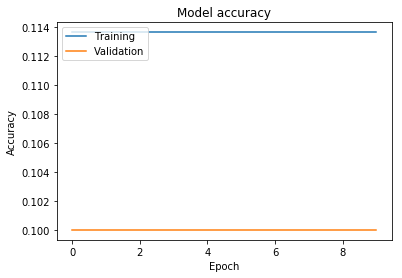

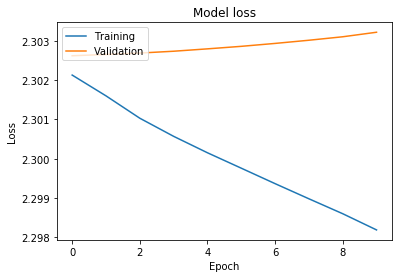

In [0]:
create_pretrained_model(True)
train_on_images( dir_train_json_img )

##Results
I was hoping the lack of data could be worked around with a pretrained model, image augmentation and feature extraction. But the results of models trained on generated images are disappoining.  More data is probably needed.

## Plot an activation

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1, 150, 150, 3)


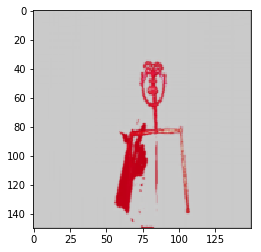

3
[<tensorflow.python.keras.engine.training.Model object at 0x7f35cfebc1d0>, <tensorflow.python.keras.layers.core.Flatten object at 0x7f35cfecd438>, <tensorflow.python.keras.layers.core.Dense object at 0x7f35cfecd860>]
[<tf.Tensor 'Reshape_13:0' shape=(?, 8192) dtype=float32>]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 8192)              0         
Total params: 14,714,688
Trainable params: 4,719,616
Non-trainable params: 9,995,072
_________________________________________________________________
None
(1, 8192)
[[0.2741431  0.         0.         ... 0.         0.40540284 0.        ]]
Length of the activa

IndexError: ignored

In [0]:
x = 0 # the first image
#image = validation_images[x].reshape(1,28,28,1)
# the validation images are supposed to be the last

# predict_image(image, validation_labels[x], model) 
img = imageio.imread('/content/gdrive/My Drive/stud/dl-umu/lab2/data/train/7/155794869141474_comp-diff.jpg')
img = resize(img, (150, 150), anti_aliasing=True)
img = img.reshape(1,150,150,3)
print(img.shape)

plot_activation(pretrained_model, img)

## Generate data from uploaded movies and predict

Here a frame that is descriptive of the video sequence is generated. The image is then predicted.

/content/gdrive/My Drive/stud/dl-umu/lab2/vid/
['/content/gdrive/My Drive/stud/dl-umu/lab2/vid/1/orig_nummer-ett-01289-tecken.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/1/orig_422266.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/2/orig_nummer-tva-01297-tecken.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/2/orig_422268.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/3/orig_nummer-tre-01305-tecken.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/3/orig_422270.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/4/orig_nummer-fyra-01312-tecken.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/4/orig_422272.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/0/orig_noll-01789-tecken.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/0/orig_388974.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/5/orig_nummer-fem-01323-tecken.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/5/orig_422274.mp4', '/content/gdrive/My Drive/stud/dl-umu/lab2/vid/6/or

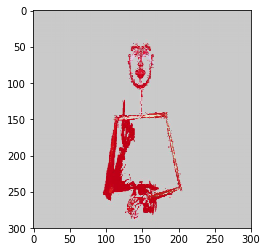

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/1/orig_422266.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/1/orig_422266.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589685701/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589685701/_label_only_overlay_422266.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 22.369229 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589685701/_label_only_overlay_422266.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589685701/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589685701/frames/'], returncode=0)
b

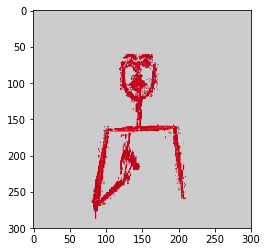

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/2/orig_nummer-tva-01297-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/2/orig_nummer-tva-01297-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589686004/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589686004/_label_only_overlay_nummer-tva-01297-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 73.710101 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589686004/_label_only_overlay_nummer-tva-01297-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589686004/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/s

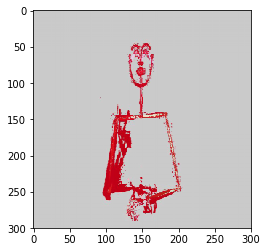

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/2/orig_422268.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/2/orig_422268.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687019/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687019/_label_only_overlay_422268.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 24.280730 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687019/_label_only_overlay_422268.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687019/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687019/frames/'], returncode=0)
b

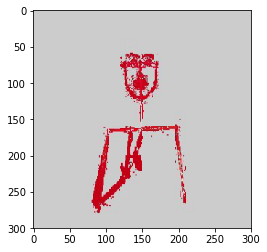

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/3/orig_nummer-tre-01305-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/3/orig_nummer-tre-01305-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687340/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687340/_label_only_overlay_nummer-tre-01305-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 90.183788 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687340/_label_only_overlay_nummer-tre-01305-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589687340/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/s

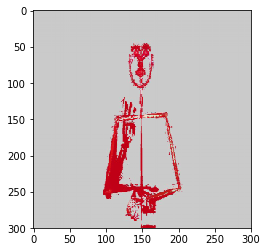

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/3/orig_422270.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/3/orig_422270.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688573/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688573/_label_only_overlay_422270.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 23.825879 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688573/_label_only_overlay_422270.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688573/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688573/frames/'], returncode=0)
b

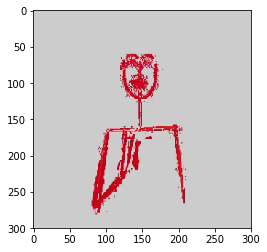

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/4/orig_nummer-fyra-01312-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/4/orig_nummer-fyra-01312-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688891/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688891/_label_only_overlay_nummer-fyra-01312-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 71.267135 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688891/_label_only_overlay_nummer-fyra-01312-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589688891/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Dri

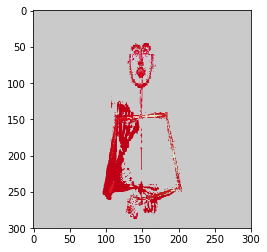

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/4/orig_422272.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/4/orig_422272.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589689876/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589689876/_label_only_overlay_422272.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 24.294411 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589689876/_label_only_overlay_422272.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589689876/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589689876/frames/'], returncode=0)
b

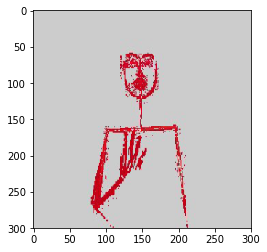

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/0/orig_noll-01789-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/0/orig_noll-01789-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690199/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690199/_label_only_overlay_noll-01789-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 40.903019 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690199/_label_only_overlay_noll-01789-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690199/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/tes

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/0/orig_388974.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/0/orig_388974.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690735/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690735/_label_only_overlay_388974.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 29.121473 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690735/_label_only_overlay_388974.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690735/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589690735/frames/'], returncode=0)
b

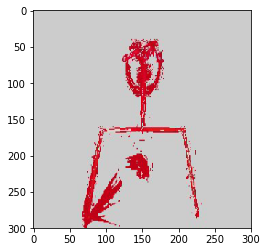

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/5/orig_nummer-fem-01323-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/5/orig_nummer-fem-01323-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589691112/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589691112/_label_only_overlay_nummer-fem-01323-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 86.099868 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589691112/_label_only_overlay_nummer-fem-01323-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589691112/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/s

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/5/orig_422274.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/5/orig_422274.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692288/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692288/_label_only_overlay_422274.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 23.311271 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692288/_label_only_overlay_422274.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692288/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692288/frames/'], returncode=0)
b

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/6/orig_nummer-sex-01324-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/6/orig_nummer-sex-01324-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692606/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692606/_label_only_overlay_nummer-sex-01324-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 77.090226 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692606/_label_only_overlay_nummer-sex-01324-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589692606/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/s

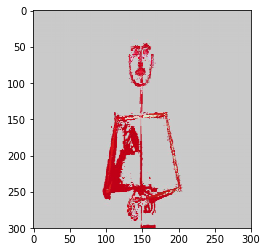

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/6/orig_422276.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/6/orig_422276.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693656/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693656/_label_only_overlay_422276.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 25.475146 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693656/_label_only_overlay_422276.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693656/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693656/frames/'], returncode=0)
b

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/7/orig_nummer-sju-01328-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/7/orig_nummer-sju-01328-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693994/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693994/_label_only_overlay_nummer-sju-01328-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 89.842249 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693994/_label_only_overlay_nummer-sju-01328-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589693994/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/s

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/7/orig_422278.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/7/orig_422278.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695230/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695230/_label_only_overlay_422278.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 24.913598 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695230/_label_only_overlay_422278.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695230/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695230/frames/'], returncode=0)
b

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/8/orig_nummer-atta-01330-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/8/orig_nummer-atta-01330-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695563/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695563/_label_only_overlay_nummer-atta-01330-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 69.390580 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695563/_label_only_overlay_nummer-atta-01330-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589695563/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Dri

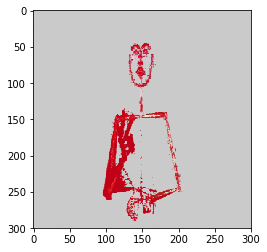

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/8/orig_422280.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/8/orig_422280.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696516/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696516/_label_only_overlay_422280.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 24.710125 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696516/_label_only_overlay_422280.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696516/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696516/frames/'], returncode=0)
b

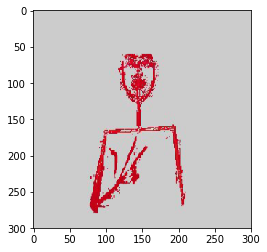

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/9/orig_nio-11886-tecken.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/9/orig_nio-11886-tecken.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696845/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696845/_label_only_overlay_nio-11886-tecken.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 87.958850 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696845/_label_only_overlay_nio-11886-tecken.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589696845/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vi

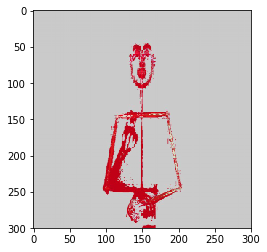

Predicted class: 0
/content/gdrive/My Drive/stud/dl-umu/lab2/vid/9/orig_422282.mp4
 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/vid/9/orig_422282.mp4
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589698049/'], returncode=0)
/content/openpose

vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589698049/_label_only_overlay_422282.avi
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 25.443854 seconds.

uploaded_mov_with_pose  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589698049/_label_only_overlay_422282.avi
path: /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589698049/frames/
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15589698049/frames/'], returncode=0)
b

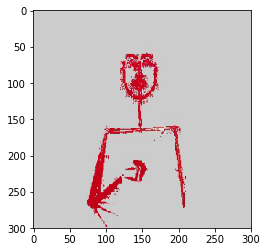

Predicted class: 0


In [0]:
def predict_movies(files):
  for i,file in enumerate (files):
    print(file)
    #print(uploaded[file]) #data
    #print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
    #plt.imshow( uploaded[file])
    #plt.show() # movie..?
    #pose_detection( video, path, gen_overlay=None, gen_stickfig=None, label, i )
    out_dir = f"{test_dir}vid/{int(time.time()*10)}/"
    uploaded_mov_with_pose = pose_detection(file, out_dir,gen_overlay=None, gen_stickfig=True, label='', i=i)['only_overlay']
    print('uploaded_mov_with_pose ', uploaded_mov_with_pose)
    img = gen_comp_img(uploaded_mov_with_pose, out_dir )
    # copy image to test dir
    predict_image(img, pretrained_model) # no class sent

  # run function with openpose and gen. of composite image. Copy to test directory?
  
# videos_to_process = glob.glob("/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/??2019-05-16*")
videos_to_process = glob.glob(f"{download_dir}**/orig*.mp4", recursive=True)
print(download_dir)
print( videos_to_process)
predict_movies( videos_to_process)

#Upload file to classify
##(firefox not working?)
wip

In [0]:
# appears not to be working in firefox
from google.colab import files
uploaded = files.upload()
print(uploaded.keys())
for file in uploaded.keys():
  print(f"/content/{file}")
#predict_movies(uploaded.keys())

for file in uploaded.keys():
  mov = f"/content/{file}"
  # todo make list with abs path
  # predict_movies([mov])

Saving 1-2019-05-16-180525.webm to 1-2019-05-16-180525.webm
dict_keys(['1-2019-05-16-180525.webm'])
1-2019-05-16-180525.webm
 video to run op on:  1-2019-05-16-180525.webm
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15580233892/'], returncode=0)
/content/openpose
vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15580233892/_label_only_overlay_1-2019-05-16-180525.avi


CalledProcessError: ignored

### Helper functions
Shuffling files around etc

In [0]:
# copy comp_img to training_dir
def copy_img_to_train_dir(comp_img, label):
  #x =  dirname( comp_img).split('/')[-2] # the folder 1 step up named from time
  x=int( round(time.time() *100000)) # just to have a new filename, not overwriting anything
  new_name = f"{ x }_{basename(comp_img)}"
  #print(new_name)
  print( subprocess.run([ "cp", "-n", comp_img, f"{train_dir}{label}/{new_name}" ]))
  
# copy_img_to_train_dir("/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15579383187/frames/comp-diff.jpg", 5)
  
def copy_gen_files():
  #files_to_process = glob.glob(f"{test_dir}vid/**/comp-diff.jpg", recursive=True)
  files_to_process = glob.glob(f"{test_dir}vid/**/frames/comp-diff.jpg", recursive= False)
  for file in files_to_process:
    # get label from folder
    label = int( file.split('/')[-3]) # label from directory name
    print (label)
    copy_img_to_train_dir(file, label)

copy_gen_files()


# move the jpgs from dictionaries because they are so different
def move_img_from_training( pattern ):
  files_to_process = glob.glob(f"{train_dir}/**/*{pattern}*.jpg", recursive= False) # only 1 or 2 chars in name
  for file in files_to_process:
    label = int(file.split('/')[-2])
    dest = f"{base_dir}not_used_img/{label}/"
    print(dest)
    dest_file = basename(file)[:-4]
    #dest_file = dest_file
    print( dest_file )
    #print( subprocess.run([ "mkdir", "-p", dest])) # create dir for label
    print( subprocess.run( [ "mv", "-vn", file, f"{dest}{dest_file}"] ))
    
#move_img_from_training('.jpg')

# put files back
def put_img_back():
  files_to_process = glob.glob( f"{base_dir}not_used_img/**/*.jpg")
  for file in files_to_process:
    label = int(file.split('/')[-2])
    new_filename = f"{label}_{basename(file)}"
    dest = f"{train_dir}{label}/"
    #print(new_filename)
    #print(dest)
    print( subprocess.run( [ "mv", "-vn", file, f"{dest}{new_filename}"] ))
    
    

# create dir structure like
#    data
#     |
#   train     test    validate
#   |
# 0 - 1 - 2 ..

# todo: make read from directory a parameter
def copy_gen_images_to_train_dir( glob_path ):
  #training_images = glob.glob(f"{base_dir}vid/**/*comp-diff*.jpg", recursive=True)
  training_images = glob.glob( glob_path, recursive=True)
  print(len(training_images), " images to copy")

  # subprocess.check_output(["mkdir", "-p", train_dir])

  for i, img in enumerate( training_images ):
    dir = dirname(img)
    label = int( dir.split('/')[-2]) # label from directory name
    class_dir = f"{train_dir}{label}/"
    # subprocess.check_output(["mkdir", "-p", class_dir])
    print(label)
    # res =subprocess.check_output(["cp", "-a", img, f"{class_dir}{i}.jpg"])
    print(res)
      
# copy_gen_images_to_train_dir( f"{base_dir}vid/**/*comp-diff*.jpg" )

# Use video
## instead of a generated image as in the previous example.
Not yet started
Inspiration:
http://cgnal.com/blog/pre-trained-3d-convolutional-network-for-video-labelling/

####Help for openpose shown below

In [0]:
# show help for openpose, see flags etc
%cd /content/openpose
#print(subprocess.check_output(["./build/examples/openpose/openpose.bin", "--help"]))

p = subprocess.Popen('./build/examples/openpose/openpose.bin --help', shell=True, stdout=subprocess.PIPE)
print(str(p.communicate()[0], 'utf-8'))

/content/openpose
openpose.bin: Warning: SetUsageMessage() never called

  Flags from /build/gflags-6Vsjoz/gflags-2.2.1/src/gflags.cc:
    -flagfile (load flags from file) type: string default: ""
    -fromenv (set flags from the environment [use 'export FLAGS_flag1=value'])
      type: string default: ""
    -tryfromenv (set flags from the environment if present) type: string
      default: ""
    -undefok (comma-separated list of flag names that it is okay to specify on
      the command line even if the program does not define a flag with that
      name.  IMPORTANT: flags in this list that have arguments MUST use the
      flag=value format) type: string default: ""

  Flags from /build/gflags-6Vsjoz/gflags-2.2.1/src/gflags_completions.cc:
    -tab_completion_columns (Number of columns to use in output for tab
      completion) type: int32 default: 80
    -tab_completion_word (If non-empty, HandleCommandLineCompletions() will
      hijack the process and attempt to do bash-style co

#### Not used

In [0]:
# test
video = "/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/9-2019-05-15-190932.webm"
#!ls -l "./build/examples/openpose/openpose.bin"
#video = "/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/2019-05-08-134130.webm"
out_dir = f"{test_dir}vid/{int(time.time()*10)}/"
x = pose_detection( video, out_dir, gen_overlay=None, gen_stickfig=True )
print(" op mov for gen img ", x['only_overlay'])
comp_img = gen_comp_img( x['only_overlay'], out_dir)
print ( comp_img )

#predict_image( f"{base_dir}vid/1/frames0/comp-diff.jpg", pretrained_model, 1 )
#predict_image( "/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15572083623/frames/comp-diff.jpg", pretrained_model, 1 )
predict_image( comp_img, pretrained_model )

 video to run op on:  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/9-2019-05-15-190932.webm
CompletedProcess(args=['mkdir', '-p', '/content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15583782029/'], returncode=0)
/content/openpose
no
vidname_stickfig  /content/gdrive/My Drive/stud/dl-umu/lab2/data/test/vid/15583782029/no_label_only_overlay_9-2019-05-15-190932.avi


CalledProcessError: ignored